# Sequence Modeling
#### 1 year-step ahead single day forecasts without considering realized prices

### Importing Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import math
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

from tensorflow.keras import Sequential
from tensorflow.keras.layers import (
    BatchNormalization, LSTM, Dense, 
    Dropout, TimeDistributed, 
    Conv1D, MaxPooling1D,
    Flatten, Bidirectional, 
    RepeatVector, ELU)
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model
from tensorflow.keras.saving import load_model
import tensorflow as tf
from tensorflow.keras import layers

from utils import *

import quantstats as qs

import warnings
warnings.filterwarnings("ignore")

2024-02-21 17:44:44.192575: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
tf.random.set_seed(2024)
np.random.seed(2024)

### Data Loading & Preparation

In [3]:
tukey = pd.read_pickle('data/tukey_estimates.pkl')

stocks_returns = pd.read_pickle('data/stocks_returns.pkl')

index_returns = pd.read_pickle('data/index_returns.pkl')

In [4]:
# create test set of returns for the benchmark (SX5E index)

test_index_ret = index_returns.loc['2017-01-02':]

In [5]:
n_features = len(tukey.columns)
LOOK_BACK = 50
FORECAST_RANGE = 1

We want to start with the first observations of the actual test set (the whole 2017 year). However our model expect as input the previous 50 observations to perform a forecast. We need to "add" the last 50 observations of the training set to the testing set to make the first real test set prediction using observed data.

In [6]:
starting_date_test = tukey.loc[:'2016-12-30'].index[-(LOOK_BACK)]
starting_date_test

Timestamp('2016-10-20 00:00:00')

In [7]:
train_price, test_price = tukey.loc[:'2016-12-30'], tukey.loc[starting_date_test:]

In [8]:
train_price.tail()

,VOW3 GY Equity,ENGI FP Equity,BAYN GY Equity,BNP FP Equity,PHIA NA Equity,ISP IM Equity,SAN FP Equity,MC FP Equity,ENEL IM Equity,CS FP Equity,...,OR FP Equity,BBVA SQ Equity,ASML NA Equity,SAP GY Equity,INGA NA Equity,ENI IM Equity,EOAN GY Equity,DBK GY Equity,ABI BB Equity,DTE GY Equity
2016-12-22,117.910687,12.246441,97.141659,61.272187,26.929365,2.434764,75.040130,179.388866,4.083631,24.033860,...,170.735369,6.469342,105.510152,82.419930,13.641402,15.163333,6.651876,15.921431,99.108056,16.068334
2016-12-23,118.660635,12.194222,97.119513,61.355614,27.066102,2.447784,75.309034,179.418824,4.100916,24.056022,...,171.326530,6.455857,105.635561,82.382622,13.636879,15.163776,6.670006,15.982123,99.197895,16.100697
2016-12-28,118.705029,12.132131,97.113473,61.164515,27.161892,2.442736,75.511610,179.724676,4.104446,24.025914,...,171.794801,6.446569,105.790196,82.388497,13.629722,15.246898,6.645022,15.861081,99.218335,16.101476
2016-12-29,117.673160,12.117201,97.124427,60.833287,27.166165,2.432600,75.680013,179.635493,4.123834,24.013731,...,172.515976,6.424458,106.055295,82.444122,13.550016,15.317679,6.644138,15.690265,99.463315,16.155551
2016-12-30,116.344625,12.110925,97.167240,60.567675,27.196551,2.431234,75.809958,180.225721,4.149813,23.984192,...,172.527198,6.415234,106.396930,82.741524,13.459414,15.390000,6.663424,15.543774,99.924694,16.234752


In [9]:
train_price.shape, test_price.shape

((1015, 41), (304, 41))

In [10]:
scaler = MinMaxScaler()
scaled_train = scaler.fit_transform(train_price)
scaled_test = scaler.transform(test_price)

In [11]:
X_train, y_train = split_sequence(scaled_train, look_back=LOOK_BACK, forecast_horizon=FORECAST_RANGE)
X_test, y_test = split_sequence(scaled_test, look_back=LOOK_BACK, forecast_horizon=FORECAST_RANGE)
print('(Samples, time steps, features)')
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(Samples, time steps, features)
(965, 50, 41)
(965, 1, 41)
(254, 50, 41)
(254, 1, 41)


In [12]:
pd.DataFrame(scaled_train).head(16)

,0,1,2,3,4,5,6,7,8,9,...,31,32,33,34,35,36,37,38,39,40
0,0.541517,0.461622,0.034626,0.257120,0.014065,0.100755,0.169548,0.254304,0.429280,0.069447,...,0.016829,0.490880,0.029313,0.324409,0.173636,0.852899,0.899366,0.831756,0.049210,0.067080
1,0.529201,0.461799,0.034262,0.278435,0.003336,0.105064,0.177072,0.245024,0.415421,0.069170,...,0.007411,0.499854,0.019219,0.311913,0.180203,0.844386,0.895234,0.851984,0.042860,0.071488
2,0.516797,0.457860,0.036727,0.296042,0.000000,0.111241,0.184239,0.234919,0.412488,0.061482,...,0.006851,0.517925,0.012093,0.304001,0.189000,0.850401,0.895617,0.872443,0.035237,0.076776
3,0.507911,0.447295,0.034189,0.308523,0.004540,0.120639,0.181054,0.218831,0.409791,0.051458,...,0.000000,0.539547,0.008084,0.297463,0.197833,0.857331,0.891148,0.892111,0.023188,0.088735
4,0.508034,0.438925,0.037815,0.311910,0.033031,0.131367,0.187847,0.211055,0.419323,0.052887,...,0.000213,0.566854,0.008834,0.300066,0.204064,0.877588,0.891316,0.905895,0.018373,0.097186
5,0.511512,0.422013,0.041265,0.309480,0.063189,0.139578,0.178564,0.203565,0.420097,0.056054,...,0.002047,0.569700,0.009525,0.304148,0.211047,0.882571,0.890789,0.912355,0.015429,0.100457
6,0.521391,0.414747,0.040609,0.312093,0.062337,0.144239,0.165171,0.205973,0.430032,0.054294,...,0.004082,0.569046,0.004856,0.296475,0.212109,0.888026,0.879558,0.912538,0.022499,0.095597
7,0.522908,0.406736,0.044093,0.281079,0.062301,0.142693,0.157912,0.218534,0.429174,0.051623,...,0.013135,0.573871,0.000000,0.272454,0.210314,0.894143,0.863180,0.907484,0.033346,0.091237
8,0.526643,0.404740,0.043780,0.278568,0.064432,0.142578,0.153651,0.232912,0.420234,0.050776,...,0.027586,0.576559,0.002910,0.238766,0.206102,0.893838,0.852046,0.902328,0.037035,0.091054
9,0.530767,0.401711,0.042236,0.284384,0.087916,0.146637,0.145950,0.247434,0.413457,0.048868,...,0.039572,0.581729,0.024365,0.222524,0.197721,0.892704,0.842585,0.900060,0.044900,0.087584


In [13]:
X_train.shape

(965, 50, 41)

Everything matches. Each row of my dataset is an element of the arrays: 965 samples where each sample has 50 timesteps for each of the 41 stocks. The sequences are ready for training.

### Useful Functions

In [14]:
def inverse_transform(y_test, yhat):
    y_test_reshaped = y_test.reshape(-1, y_test.shape[-1])
    yhat_reshaped = yhat.reshape(-1, yhat.shape[-1])
    yhat_inverse = scaler.inverse_transform(yhat_reshaped)
    y_test_inverse = scaler.inverse_transform(y_test_reshaped)
    return yhat_inverse, y_test_inverse

# aggregated metrics
def evaluate_forecast(y_test_inverse, yhat_inverse):
    mse_ = tf.keras.losses.MeanSquaredError()
    mae_ = tf.keras.losses.MeanAbsoluteError()
    mape_ = tf.keras.losses.MeanAbsolutePercentageError()
    mae = mae_(y_test_inverse,yhat_inverse)
    print('mae:', mae.numpy())
    mse = mse_(y_test_inverse,yhat_inverse)
    print('mse:', mse.numpy())
    mape = mape_(y_test_inverse,yhat_inverse)
    print('mape:', mape.numpy())


# metrics for each stock
def calculate_metrics(y_test_inverse, yhat_inverse, tukey):
    metrics_df = pd.DataFrame(columns=['Stock', 'MAE', 'MSE', 'MAPE'])
    mse_ = tf.keras.losses.MeanSquaredError()
    mae_ = tf.keras.losses.MeanAbsoluteError()
    mape_ = tf.keras.losses.MeanAbsolutePercentageError()

    for stock in range(y_test_inverse.shape[1]):
        stock_name = tukey.iloc[:, stock].name
        mae = mae_(y_test_inverse[:, stock], yhat_inverse[:, stock])
        mse = mse_(y_test_inverse[:, stock], yhat_inverse[:, stock])
        mape = mape_(y_test_inverse[:, stock], yhat_inverse[:, stock])

        metrics_df.loc[len(metrics_df)] = [stock_name, mae.numpy(), mse.numpy(), mape.numpy()]
        # metrics_df = metrics_df.append({'Stock': stock_name, 'MAE': mae.numpy(), 'MSE': mse.numpy(), 'MAPE': mape.numpy()}, ignore_index=True)
    
    return metrics_df


def plot_preds(yhat, ytest, metrics_df, model_name):
    # convert to df for nice plotting
    if isinstance(yhat, np.ndarray):
        predictions = pd.DataFrame(yhat, index=tukey.loc['2017-01-02':].index, columns=tukey.columns)
        # predictions = pd.DataFrame(yhat, columns=tukey.columns)

    if isinstance(ytest, np.ndarray):
        y_test_inverse_df = pd.DataFrame(ytest, index=tukey.loc['2017-01-02':].index, columns=tukey.columns)
        # y_test_inverse_df = pd.DataFrame(ytest, columns=tukey.columns)

    rand = np.random.choice(np.arange(41), size=8, replace=False)      # 10 stock random sample without replacement
    fig, axs = plt.subplots(2, 4, figsize=(20, 8))

    for i, stock in enumerate(rand):
        row = i // 4
        col = i % 4
        axs[row, col].plot(train_price.iloc[350:, stock])       # start from here to show why the LSTMs
        axs[row, col].plot(predictions.iloc[:, stock], color='blue',
                           label='Predicted')
        axs[row, col].plot(y_test_inverse_df.iloc[:, stock], color='red', label='Realized')
        axs[row, col].set_title(predictions.iloc[:, stock].name)
        axs[row, col].tick_params(axis='x', rotation=45)
        
        # metrics in top left
        axs[row, col].annotate(f"MAE: {metrics_df.loc[stock, 'MAE']:.2f}\nMSE: {metrics_df.loc[stock, 'MSE']:.2f}\nMAPE: {metrics_df.loc[stock, 'MAPE']:.2f}", 
                               xy=(0.05, 0.95), xycoords='axes fraction', ha='left', va='top', fontsize=10, bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="black", lw=0.5))

    plt.suptitle(f"{model_name}: predicted vs realized", fontsize=16)
    
    # bottom legend
    handles, labels = axs[0,0].get_legend_handles_labels()
    fig.legend(handles, labels, loc='lower center', bbox_to_anchor=(0.5, -0.05), ncol=2)

    plt.tight_layout()
    plt.show()
    
    
def plot_top_N(predictions, y_test_inverse_df, number_of_stocks, model_name, metrics_df):
    
    portfolios = get_ranking(predictions, N = [5, 7, 10], prices=True)
    portfolios = portfolios[f'Top {number_of_stocks}']

    # Calculate the number of rows and columns dynamically based on the number of stocks
    num_stocks = len(portfolios)
    num_rows = math.ceil(num_stocks / 5)
    num_cols = min(num_stocks, 5)

    # Create subplots dynamically
    fig, axs = plt.subplots(num_rows, num_cols, figsize=(20, 5 * num_rows), squeeze=False)
    fig.suptitle(f"{model_name}: predicted vs realized", fontsize=16)

    for i, stock in enumerate(portfolios):
        row = i // 5
        col = i % 5
        axs[row, col].plot(predictions.loc[:, stock], color='blue', label='Predicted')
        axs[row, col].plot(y_test_inverse_df.loc[:, stock], color='red', label='Realized')
        axs[row, col].set_title(predictions.loc[:, stock].name)
        axs[row, col].tick_params(axis='x', rotation=45)

        # metrics in top left
        axs[row, col].annotate(f"MAE: {metrics_df.loc[i, 'MAE']:.2f}\nMSE: {metrics_df.loc[i, 'MSE']:.2f}\nMAPE: {metrics_df.loc[i, 'MAPE']:.2f}",
                            xy=(0.05, 0.95), xycoords='axes fraction', ha='left', va='top', fontsize=10,
                            bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="black", lw=0.5))

    # bottom legend
    handles, labels = axs[0, 0].get_legend_handles_labels()
    fig.legend(handles, labels, loc='lower center', bbox_to_anchor=(0.5, -0.05), ncol=2)

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()


def forecast(model):
    predictions = []
    # take first batch of LOOK_BACK observations and predict
    input_seq = X_test[0].reshape(1, LOOK_BACK, n_features)
    yhat = model.predict(input_seq, verbose=0)
    predictions.append(yhat)
    # concatenate prediction to input
    new_input_seq = np.concatenate((input_seq, yhat), axis=1)
    # drop first batch to predict a new example
    new_input_seq = new_input_seq[:, 1:, :]

    for i in range(X_test.shape[0]-1):
        # single prediction and store
        yhat = model.predict(new_input_seq, verbose=0)
        predictions.append(yhat)
        # concatenate prediction to input
        new_input_seq = np.concatenate((new_input_seq, yhat), axis=1)
        new_input_seq = new_input_seq[:, 1:, :]

    predictions = np.array(predictions).reshape(X_test.shape[0],FORECAST_RANGE,n_features)
    return predictions



def MC_portfolios(model_initialized, n_sim, X_train, y_train, X_test, y_test, stocks_returns, date_index, stocks_names, LOOK_BACK=LOOK_BACK):

    best_ret = []
    best_cumret = []
    best_list = []
    best_perf = []

    worst_ret = []
    worst_cumret = []
    worst_perf = []


    for _ in range(n_sim):

        model = model_initialized
        model.compile(optimizer='adam', loss='mse')

        ### FIT MODEL
        model.fit(X_train, y_train, epochs=40, batch_size=32, verbose=0)            

        ### MODEL PREDICT
        # yhat = model.predict(X_test, verbose=0)           # for 21-step ahead forecast
        yhat = forecast(model=model)                        # for 1-step ahead forecast

        ### PROCESS PREDICTIONS
        yhat_inverse, y_test_inverse = inverse_transform(y_test, yhat)

        yhat_inverse_df = pd.DataFrame(yhat_inverse, index=date_index, columns=stocks_names)

        ### CALCULATE RANKING AND PORTFOLIOS PERFORMANCE
        ranking = get_ranking(yhat_inverse_df, N = [5, 7, 10], prices=True)
        performance, returns = calc_portfolios(ranking, stocks_returns.loc[yhat_inverse_df.index[0]:])

        # Get the best portfolio for this simulation and store it
        best = max(performance, key=lambda k: performance[k]).split(' total performance')[0]
        best_list.append(int(best[4:5]))
        best_perf.append(max(performance.values()))

        worst = min(performance, key=lambda k: performance[k]).split(' total performance')[0]
        worst_perf.append(min(performance.values()))

        # Store the best portfolio returns and cumreturns
        best_ret.append(returns[best + ' returns']) 
        best_cumret.append(((1 + returns[best + ' returns']).cumprod())) 

        # Store the worst portfolio returns and cumreturns
        worst_ret.append(returns[worst + ' returns'])
        worst_cumret.append(((1 + returns[worst + ' returns']).cumprod())) 

        print(performance)
        print(f'{_+1}/{n_sim} \n')

    return best_ret, best_cumret, best_list, best_perf, worst_ret, worst_cumret,  worst_perf


def compare_MC(test_index_returns, best_returns, best_perf, worst_returns, worst_perf, best_list):

    index_final_perf = ((1 + test_index_returns).cumprod() - 1)[-1] * 100

    unique_values, counts = np.unique(best_list, return_counts=True)
    # Create a DataFrame to store unique values and their counts
    best_counter = pd.DataFrame({'Top': unique_values, 'Frequency': counts})
    best_counter.sort_values(by='Frequency', inplace=True, ascending=False)

    print('Number of times an N-portfolio was the best performing: ')
    # Locate where 'Top' is 1 and replace it with 10
    best_counter.loc[best_counter['Top'] == 1, 'Top'] = 10
    display(best_counter)

        
    best_sharpe = np.mean([qs.stats.sharpe(series) for series in best_returns])
    best_md = np.mean([qs.stats.max_drawdown(series) for series in best_returns]) * 100
    best_avg_aret = np.mean([((1 + np.mean(series)) ** 254 - 1)  for series in best_returns]) * 100
    best_vol = np.mean([qs.stats.volatility(series) for series in best_returns])  * 100

    worst_sharpe = np.mean([qs.stats.sharpe(series) for series in worst_returns])
    worst_md = np.mean([qs.stats.max_drawdown(series) for series in worst_returns]) * 100
    worst_avg_aret = np.mean([((1 + np.mean(series)) ** 254 - 1)  for series in worst_returns]) * 100
    worst_vol = np.mean([qs.stats.volatility(series) for series in worst_returns]) * 100
 
    print('\n')
    print('Average metrics of best portfolio & worst portfolio vs SX5E metrics')

    display(pd.DataFrame(
        {'Sharpe ratio' : [qs.stats.sharpe(test_index_returns), best_sharpe, worst_sharpe],
        'Max_drawdown' : [(qs.stats.max_drawdown(test_index_returns)*100), best_md, worst_md],
        'Annualized Return' : [((1 + np.mean(test_index_returns)) ** 254 - 1) * 100, best_avg_aret, worst_avg_aret],
        'Annualized Vol' : [qs.stats.volatility(test_index_returns)*100, best_vol, worst_vol]},
        index=['Benchmark', 'Best performing', 'Worst performing']
    ).T)

    print('\n')
    print('Min and max performance of BEST and WORST performing portfolios')
    display(pd.DataFrame(
        {'Min ': [min(best_perf), min(worst_perf)],
        'Max' : [max(best_perf), max(worst_perf)]},
        index=['Best performing', 'Worst performing']
    ))

    print('\n')
    print('Frequency of WORST performing portfolios with performance smaller than SX5E performance: ', 
      sum(1 for worst in worst_perf if worst < index_final_perf))
    
    print('\n')
    print('Frequency of BEST performing portfolios with performance smaller than SX5E performance: ', 
      sum(1 for best in best_perf if best < index_final_perf))

## Sequence-2-Sequence Modeling (many-to-one) with LSTMs:

#### What we will do:

Using encoder-decoder architectures to forecast multiple time series with one model. The encoder is basically responsible for reading and interpreting the input. The encoder part compresses the input into a small representation (a fixed-length vector) of the original input, and this "context vector" is given to the decoder part as input to be interpreted and perform forecasting.
- **RepeatVector** layer is used to repeat N times the context vector we obtain from the encoder part. N is the number of future steps you want to forecast and is fed into the decoder part.
- A fully connected Dense layer is applied to each time step via **TimeDistributed** wrapper, so separates the output for each time step. The TimeDistributed allows to treat independently each time series.

One thing to mention about these models is the stochasticity associated to them, meaning that every run leads to different results (in many cases similar results). But what is affecting the performance of the strategy is not the non-deterministic component of these models, but the fact that stocks and financial time series are "impossible" to forecast, in the sense that they depend on much more than their past and current values of the series. To mention some of them: Politics, economic situations, Government decisions, news, conflicts, wars, etc...

However we may recall that the objective of this architecture is not to exactly predict stock prices, but rather to try to capture trend and guess the possible (future) best performing stocks.

---

### LSTM

In [15]:
# lstm = Sequential(name='LSTM')
# lstm.add(LSTM(100, activation='relu', input_shape=(LOOK_BACK, n_features)))
# lstm.add(RepeatVector(FORECAST_RANGE))
# lstm.add(LSTM(100, activation='relu', return_sequences=True))
# lstm.add(TimeDistributed(Dense(n_features)))

In [16]:
# Keep separate the compile step 
# lstm.compile(optimizer='adam', loss='mse')

In [17]:
# history = lstm.fit(X_train, y_train, epochs=30, batch_size=32)

Epoch 30/30

31/31 [==============================] - 1s 22ms/step - loss: 0.0017

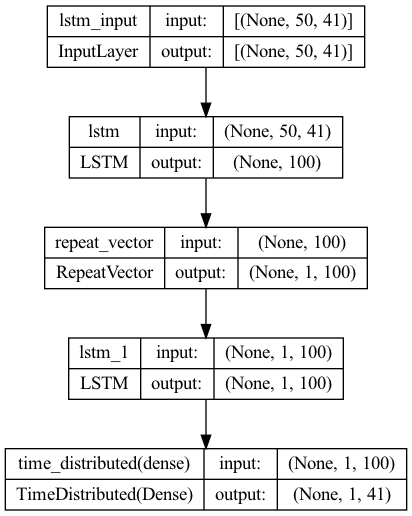

In [18]:
# lstm.save('Models/LSTM.h5')
lstm = load_model('Models/LSTM.h5')
plot_model(model=lstm, show_shapes=True, to_file='model images/LSTM.png')

Overall, making predictions using an LSTM model for time series prediction involves initializing the input sequence for prediction, iteratively feeding the input sequence into the trained model, and updating the input sequence with the predicted output for the next time step.

In [19]:
yhat = forecast(model=lstm)

In [20]:
yhat_inverse, y_test_inverse = inverse_transform(y_test, yhat)

In [21]:
evaluate_forecast(y_test_inverse, yhat_inverse)

mae: 3.1584743e+28
mse: inf
mape: 6.038767e+28


In [22]:
metrics_df = calculate_metrics(y_test_inverse, yhat_inverse, tukey)

In [23]:
metrics_df.T

,0,1,2,3,4,5,6,7,8,9,...,31,32,33,34,35,36,37,38,39,40
Stock,VOW3 GY Equity,ENGI FP Equity,BAYN GY Equity,BNP FP Equity,PHIA NA Equity,ISP IM Equity,SAN FP Equity,MC FP Equity,ENEL IM Equity,CS FP Equity,...,OR FP Equity,BBVA SQ Equity,ASML NA Equity,SAP GY Equity,INGA NA Equity,ENI IM Equity,EOAN GY Equity,DBK GY Equity,ABI BB Equity,DTE GY Equity
MAE,229973561986506346854157910016.0,12312845720827479404172017664.0,73949496537346165304029347840.0,25850878730253349606343573504.0,10953383844246793831577550848.0,1968866447764418064310861824.0,13104152602304393656638898176.0,79808040784161832807914536960.0,2943677112068017245961322496.0,6065767591042091122918686720.0,...,48126222400368430208782434304.0,6947118195431122335497715712.0,23477433864245755965698211840.0,14123151925527730005318041600.0,6371635858433368402115428352.0,11931982141617559648042221568.0,10770800627736363303857815552.0,32774141891396255929044303872.0,38506485616323715034238681088.0,9090146404527488453348163584.0
MSE,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,...,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf
MAPE,158328433899439599455410585600.0,84945484391409788357313560576.0,71286426573760934887605403648.0,41115288505471048922689437696.0,36463497789687890556712124416.0,70000875635595262849661796352.0,18137392470741347614752505856.0,31951340367253463295235981312.0,55970021182383599342634139648.0,24121382841399585091505618944.0,...,25728595411362681578357522432.0,96106013660836038458778583040.0,15990863217193744013681754112.0,14878362218201209407182733312.0,41092776984447209323955748864.0,85272612162411134420556709888.0,117210647262099112490403102720.0,201407400447649918599085162496.0,40982372778444199888504750080.0,60642670590921592931520348160.0


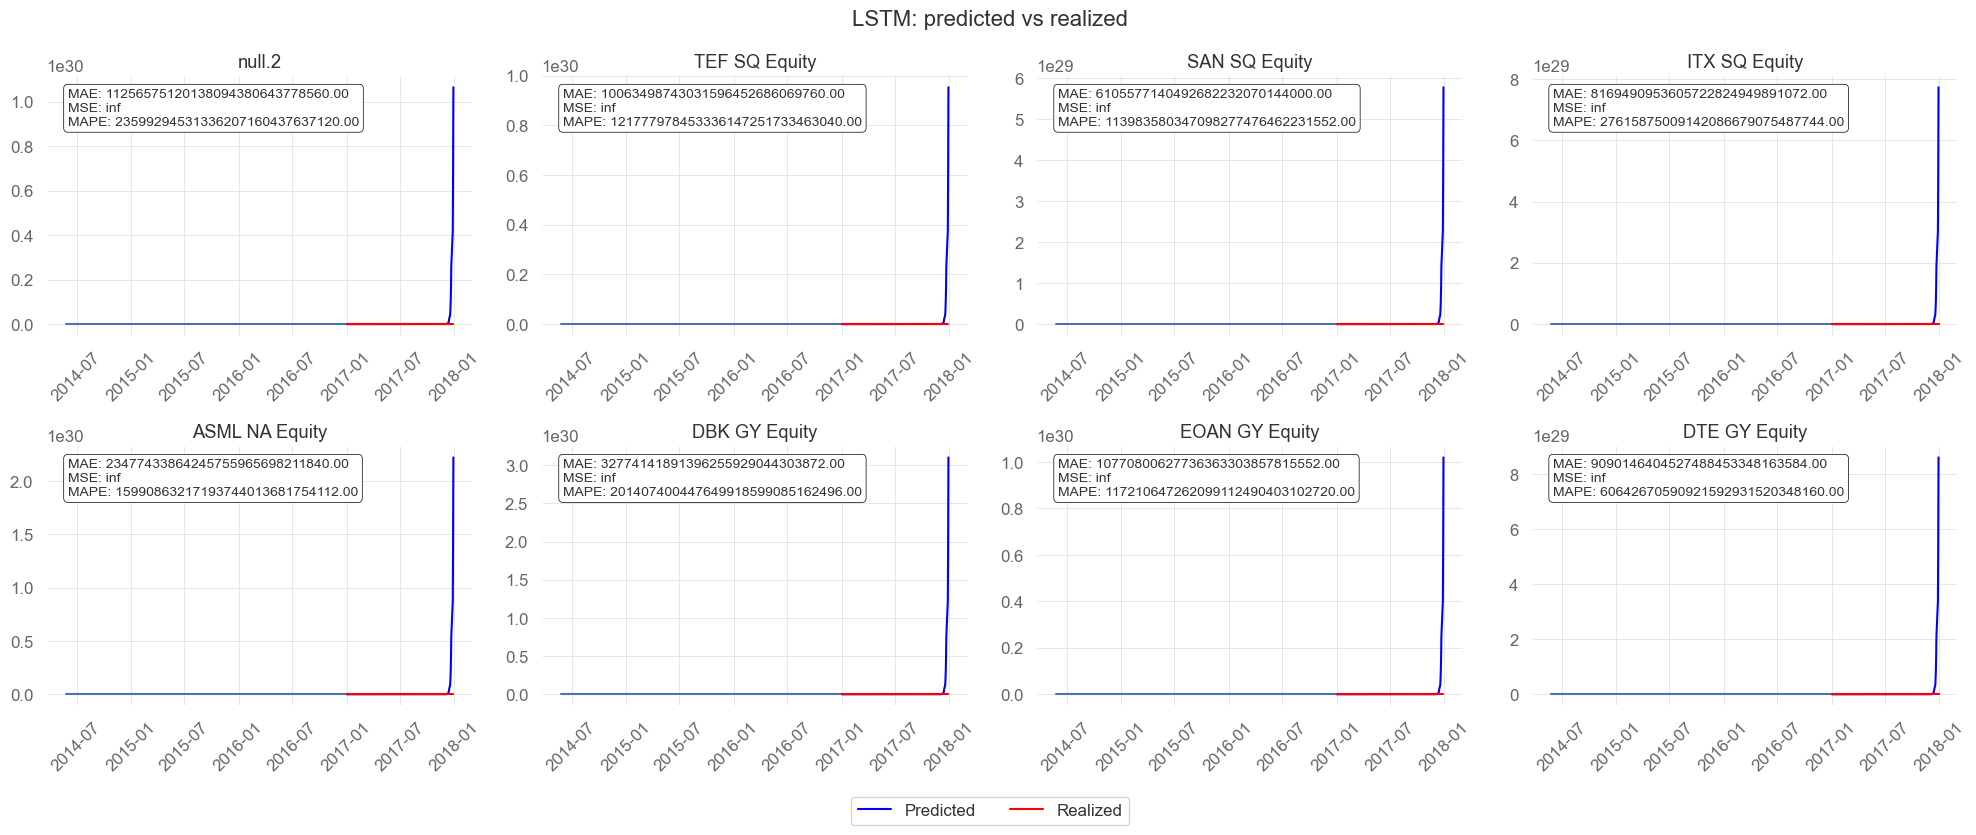

In [24]:
plot_preds(yhat_inverse, y_test_inverse, metrics_df, model_name=lstm.name)

### Portfolio creation, optimization and comparison:
- Ranking the predictions
- Selecting stocks
- Calculate performance of portfolios for different N selections
- Plot the portfolios
- Compare with index

In [25]:
# convert to dataframes
yhat_inverse_df = pd.DataFrame(yhat_inverse, index=tukey.loc['2017-01-02':].index, columns=tukey.columns)
y_test_inverse_df = pd.DataFrame(y_test_inverse, index=tukey.loc['2017-01-02':].index, columns=tukey.columns)

In [26]:
ranking_LSTM = get_ranking(yhat_inverse_df, N = [5, 7, 10], prices=True)
 
perf_LSTM, portfolios_ret_LSTM = calc_portfolios(ranking_LSTM, stocks_returns.loc[yhat_inverse_df.index[0]:])

perf_LSTM['Index total performance'] = ((1 + test_index_ret).prod() - 1) * 100
perf_LSTM

{'Top 5 total performance': -2.6286624214252874,
 'Top 7 total performance': 1.5506407007646716,
 'Top 10 total performance': 2.980560177843139,
 'Index total performance': 8.73696808872011}

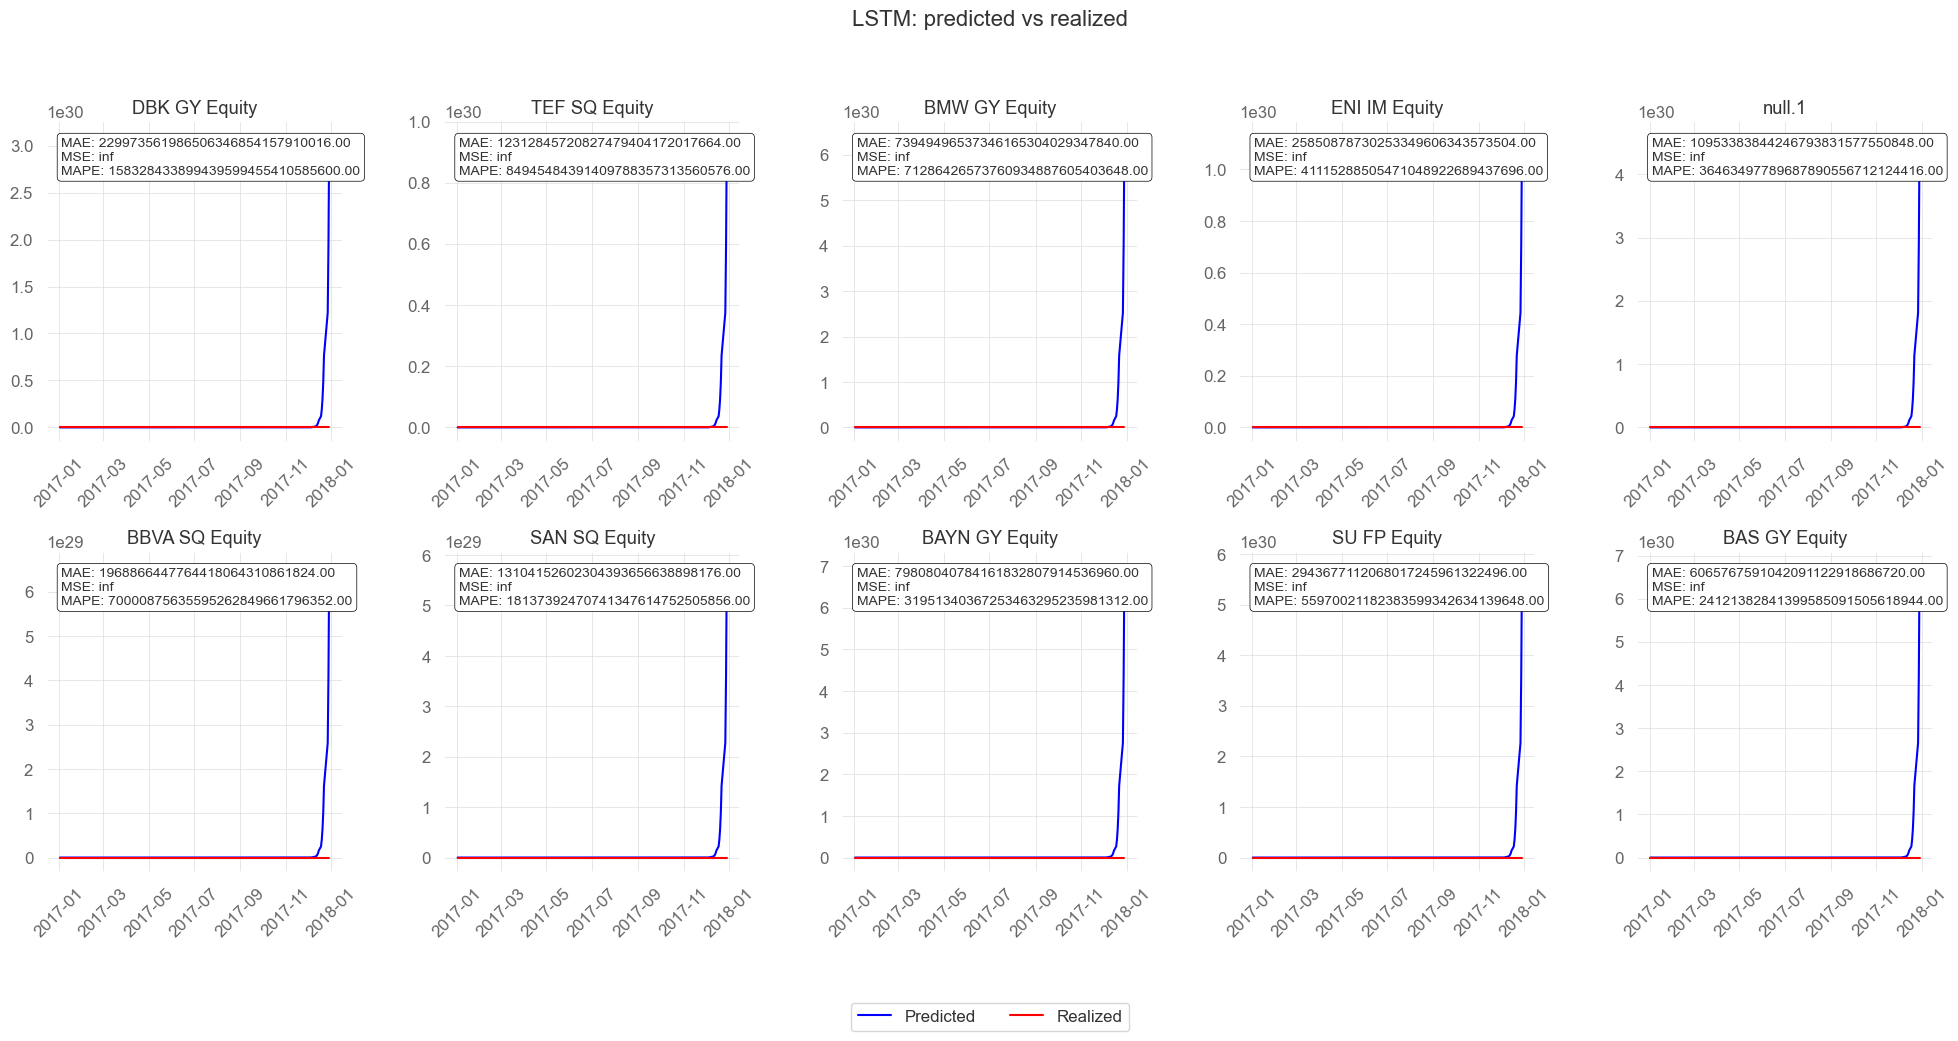

In [27]:
plot_top_N(yhat_inverse_df, y_test_inverse_df, 10, lstm.name, metrics_df)

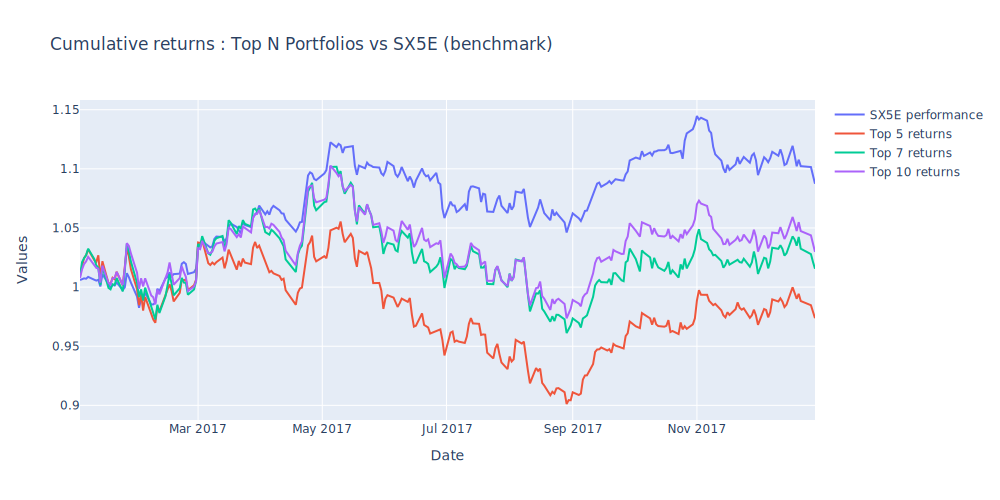

In [28]:
plot_portfolios(portfolios_ret_LSTM, test_index_ret, renderer=True)

By running this a few times we notice inconsistency with the predictions of the model. Hence running Monte Carlo simulations on this strategy is not useful.

---

### CNN encoder - LSTM decoder

In [29]:
# cnn_lstm = Sequential(name='CNN-LSTM')
# cnn_lstm.add(Conv1D(filters=64, kernel_size=9, activation='elu', input_shape=(LOOK_BACK, n_features)))
# cnn_lstm.add(Conv1D(filters=64, kernel_size=11, activation='elu'))
# cnn_lstm.add(MaxPooling1D(pool_size=2))
# cnn_lstm.add(Flatten())
# cnn_lstm.add(RepeatVector(FORECAST_RANGE))
# cnn_lstm.add(LSTM(200, activation='relu', return_sequences=True))
# cnn_lstm.add(TimeDistributed(Dense(100, activation='relu')))
# cnn_lstm.add(TimeDistributed(Dense(n_features)))

In [30]:
# cnn_lstm.compile(loss='mse', optimizer='adam')

In [31]:
# history = cnn_lstm.fit(X_train, y_train, epochs=50, batch_size=32)

Epoch 50/50

31/31 [==============================] - 0s 13ms/step - loss: 8.4179e-04

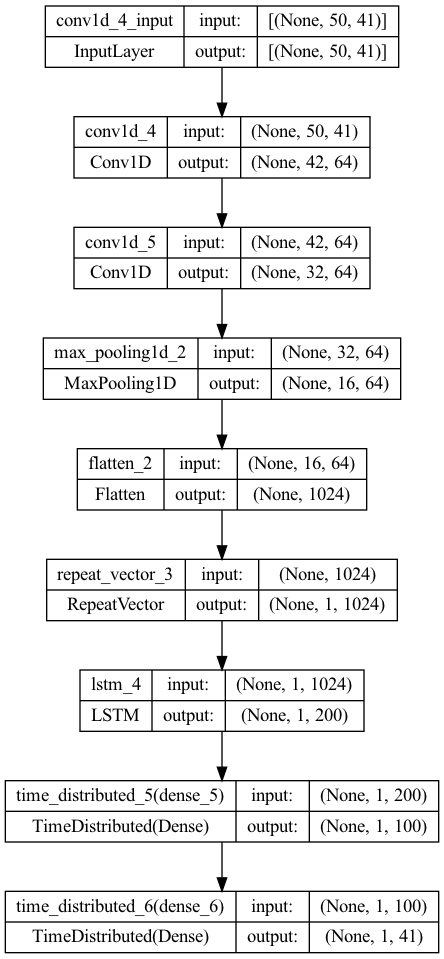

In [32]:
# cnn_lstm.save('Models/CNN_LSTM.h5')
cnn_lstm = load_model('Models/CNN_LSTM.h5')
plot_model(model=cnn_lstm, show_shapes=True, to_file='model images/CNN-LSTM.png')

In [33]:
yhat = forecast(model=cnn_lstm)

In [34]:
yhat_inverse, y_test_inverse = inverse_transform(y_test, yhat)

In [35]:
evaluate_forecast(y_test_inverse, yhat_inverse)

mae: 8.951195
mse: 284.93146
mape: 11.788256


In [36]:
metrics_df = calculate_metrics(y_test_inverse, yhat_inverse, tukey)

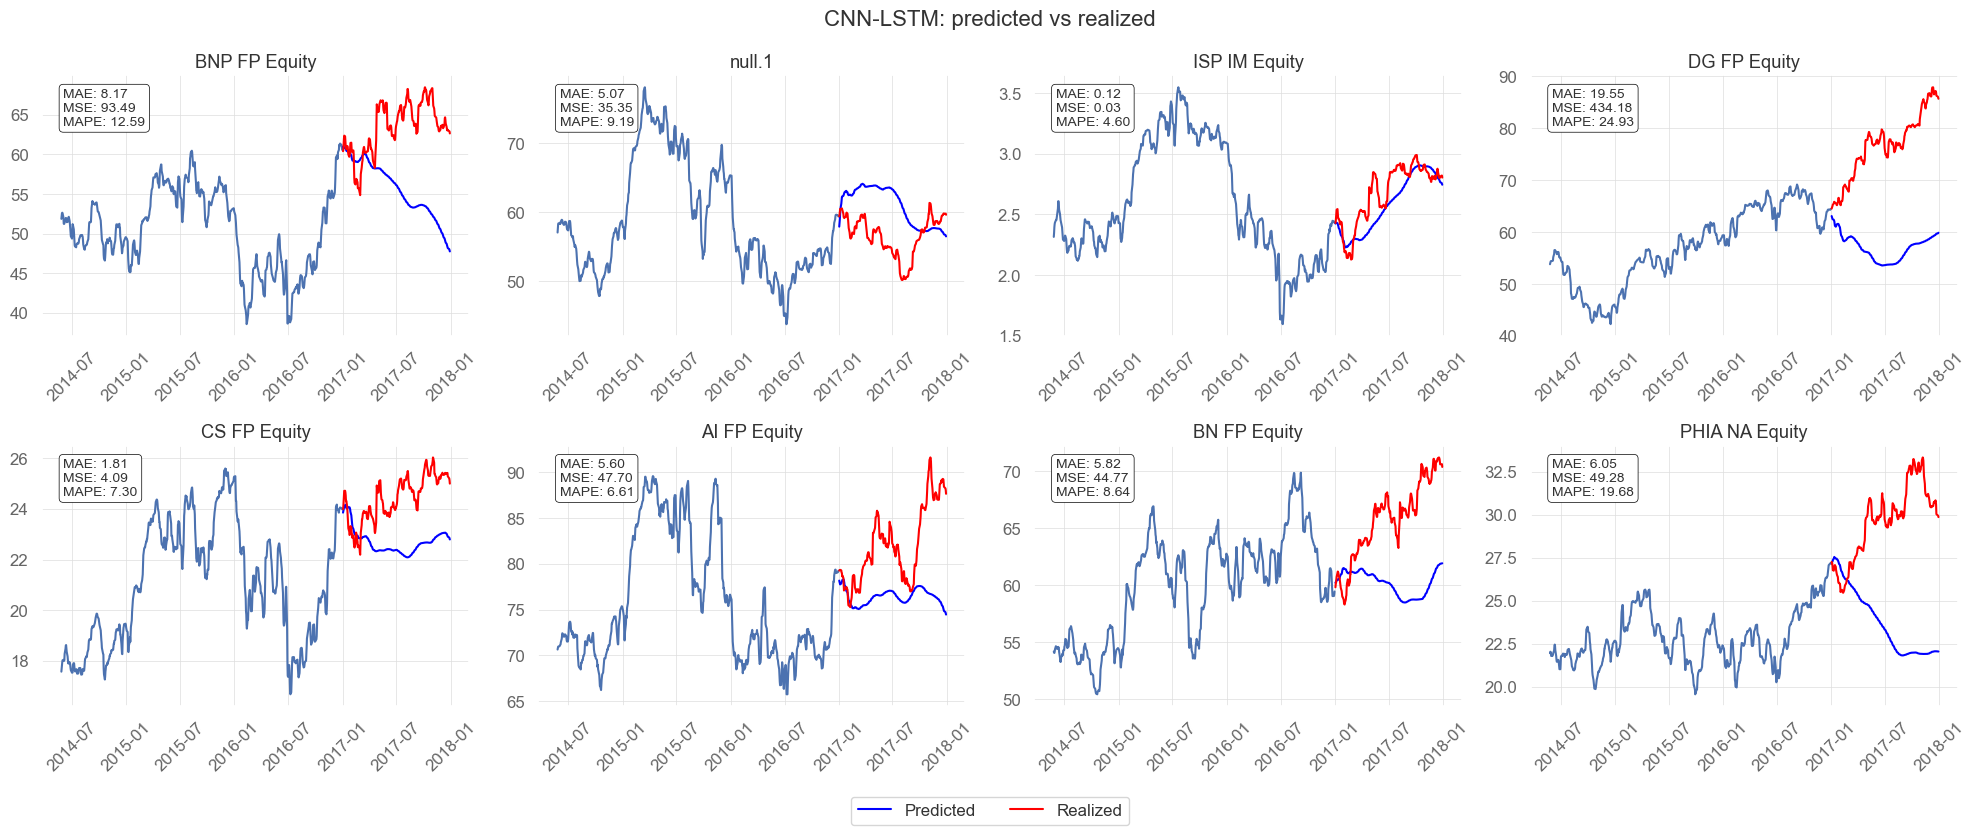

In [37]:
plot_preds(yhat_inverse, y_test_inverse, metrics_df, model_name=cnn_lstm.name)

### Portfolio creation, optimization and comparison + pseudo-MC simulations:

In [38]:
# convert to dataframes
yhat_inverse_df = pd.DataFrame(yhat_inverse, index=tukey.loc['2017-01-02':].index, columns=tukey.columns)
y_test_inverse_df = pd.DataFrame(y_test_inverse, index=tukey.loc['2017-01-02':].index, columns=tukey.columns)

In [39]:
ranking_CNN_LSTM = get_ranking(yhat_inverse_df, N = [5, 7, 10], prices=True)
 
perf_CNN_LSTM, portfolios_ret_CNN_LSTM = calc_portfolios(ranking_CNN_LSTM, stocks_returns.loc[yhat_inverse_df.index[0]:])

perf_CNN_LSTM['Index total performance'] = ((1 + test_index_ret).prod() - 1) * 100
perf_CNN_LSTM

{'Top 5 total performance': 8.537229444703677,
 'Top 7 total performance': 9.337417507672852,
 'Top 10 total performance': 10.01394191609144,
 'Index total performance': 8.73696808872011}

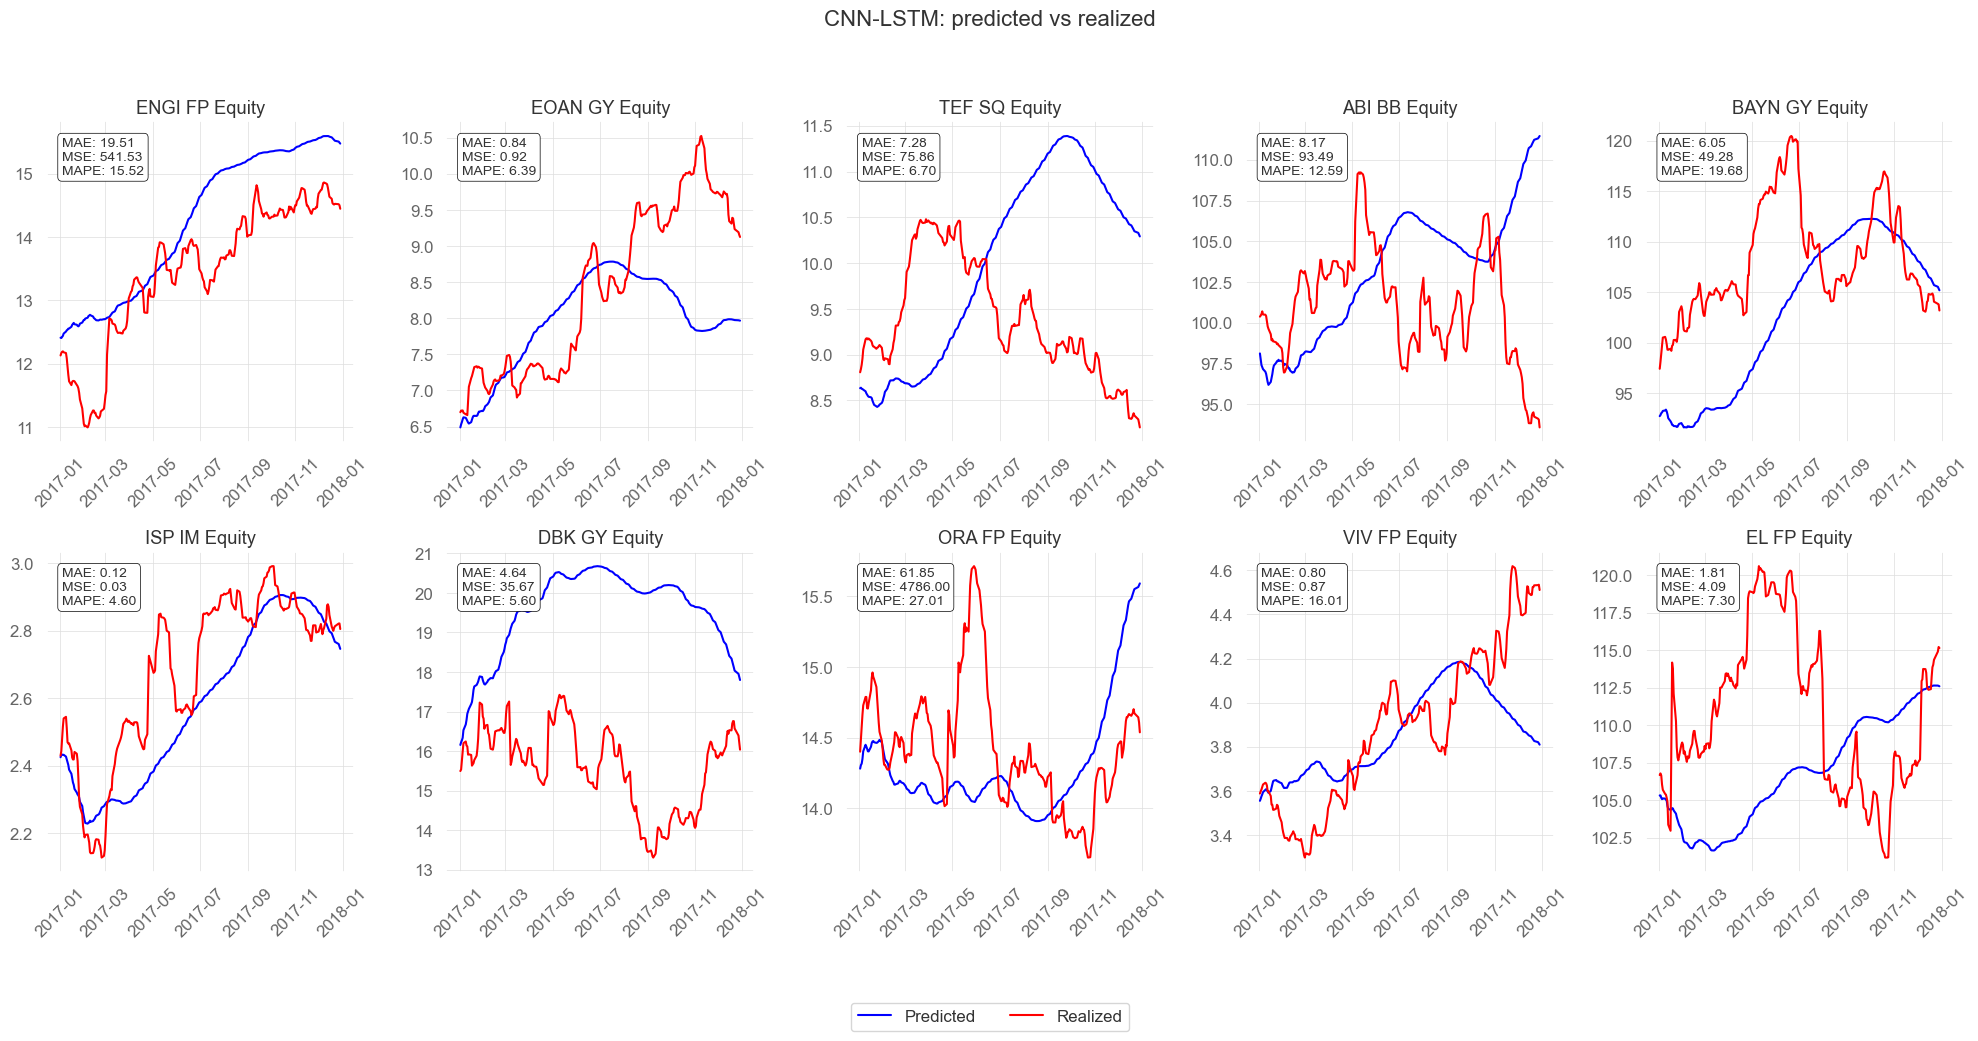

In [40]:
plot_top_N(yhat_inverse_df, y_test_inverse_df, 10, cnn_lstm.name, metrics_df)

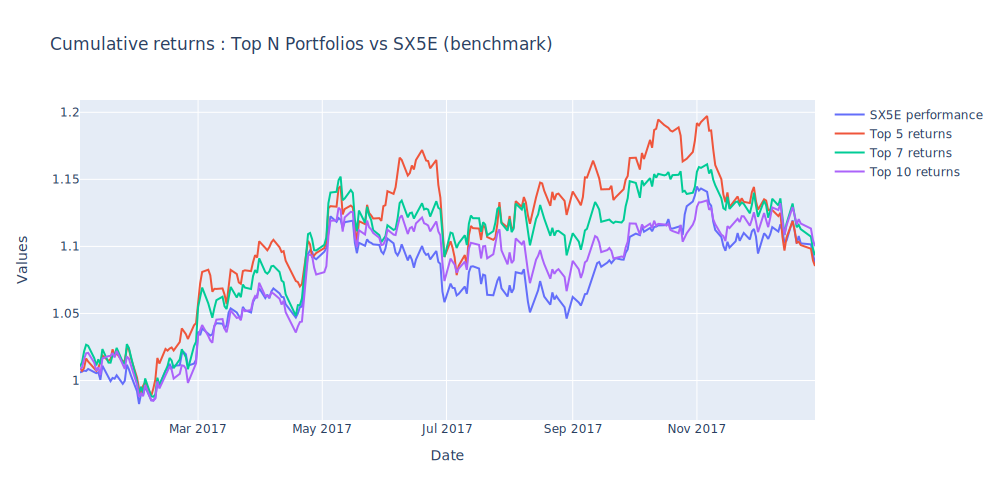

In [41]:
plot_portfolios(portfolios_ret_CNN_LSTM, test_index_ret, renderer=True)

We notice consistency with the predictions meaning that the forecasts do not "explode", thus we can run a pseudo MC simulation (30 simulations) to test if our strategy is on average outperforming the SX5E index.

In [42]:
best_ret1, best_cumret1, best_list1, best_perf1, worst_ret1, worst_cumret1,  worst_perf1 = MC_portfolios(model_initialized=cnn_lstm,
                                                                                                n_sim=50, 
                                                                                                X_train=X_train, y_train=y_train, 
                                                                                                X_test=X_test, y_test=y_test, 
                                                                                                stocks_returns=stocks_returns, 
                                                                                                date_index=tukey.loc['2017-01-02':].index, 
                                                                                                stocks_names=tukey.columns, 
                                                                                                LOOK_BACK=LOOK_BACK)

{'Top 5 total performance': 7.453777892162239, 'Top 7 total performance': 11.16632986188626, 'Top 10 total performance': 11.009869909463088}
1/50 

{'Top 5 total performance': 8.76028942275382, 'Top 7 total performance': 11.904768292229528, 'Top 10 total performance': 9.454704049231966}
2/50 

{'Top 5 total performance': 10.677039623530016, 'Top 7 total performance': 13.318576740534315, 'Top 10 total performance': 12.03618463034173}
3/50 

{'Top 5 total performance': 8.137758629663683, 'Top 7 total performance': 10.323938738081061, 'Top 10 total performance': 8.676164459969016}
4/50 

{'Top 5 total performance': 16.730034832420216, 'Top 7 total performance': 10.23284580197048, 'Top 10 total performance': 8.676164459968994}
5/50 

{'Top 5 total performance': 10.481833624584858, 'Top 7 total performance': 9.337417507672852, 'Top 10 total performance': 10.01394191609144}
6/50 

{'Top 5 total performance': 13.401037635263346, 'Top 7 total performance': 14.091492907112467, 'Top 10 total per

In [43]:
compare_MC(test_index_ret, best_ret1, best_perf1, worst_ret1, worst_perf1, best_list1)

Number of times an N-portfolio was the best performing: 


,Top,Frequency
2,7,27
1,5,16
0,10,7




Average metrics of best portfolio & worst portfolio vs SX5E metrics


,Benchmark,Best performing,Worst performing
Sharpe ratio,0.885662,1.252651,0.942780
Max_drawdown,-6.794479,-6.270193,-6.224821
Annualized Return,9.275149,16.175496,11.247893
Annualized Vol,9.937853,11.946904,11.290937




Min and max performance of BEST and WORST performing portfolios


,Min,Max
Best performing,8.559897,19.233233
Worst performing,4.929821,15.549730




Frequency of Worst performing portfolios with performance smaller than SX5E performance:  12


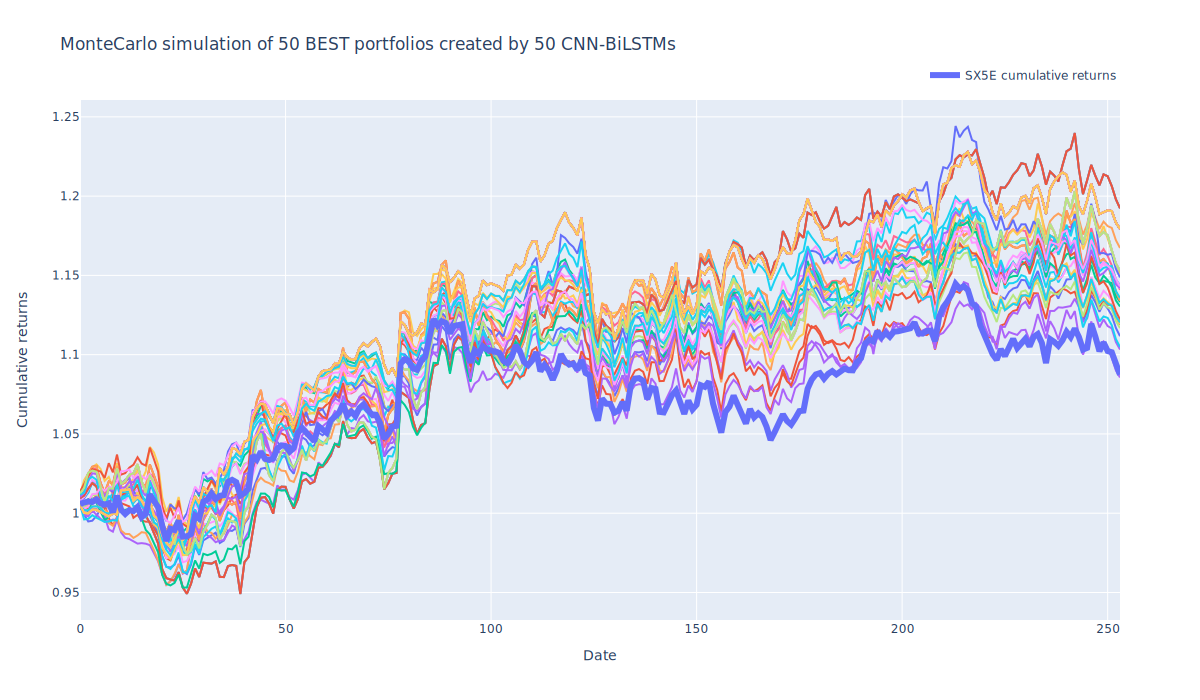

In [44]:
fig = go.Figure()

for series in best_cumret1:
    fig.add_trace(go.Scatter(y=series, mode='lines', name='BEST portfolio', showlegend=False))

fig.add_trace(go.Scatter(y=(1+test_index_ret).cumprod(), mode='lines', name='SX5E cumulative returns', line=dict(width=6), showlegend=True))

fig.update_layout(
    title='MonteCarlo simulation of 50 BEST portfolios created by 50 CNN-BiLSTMs',
    xaxis_title='Date',
    yaxis_title='Cumulative returns',
    showlegend=True,
    width=1200,
    height=700,
    legend=dict(
        orientation="h",
        yanchor="bottom",
        y=1.02,
        xanchor="right",
        x=1)
    )

fig.show(renderer='svg')

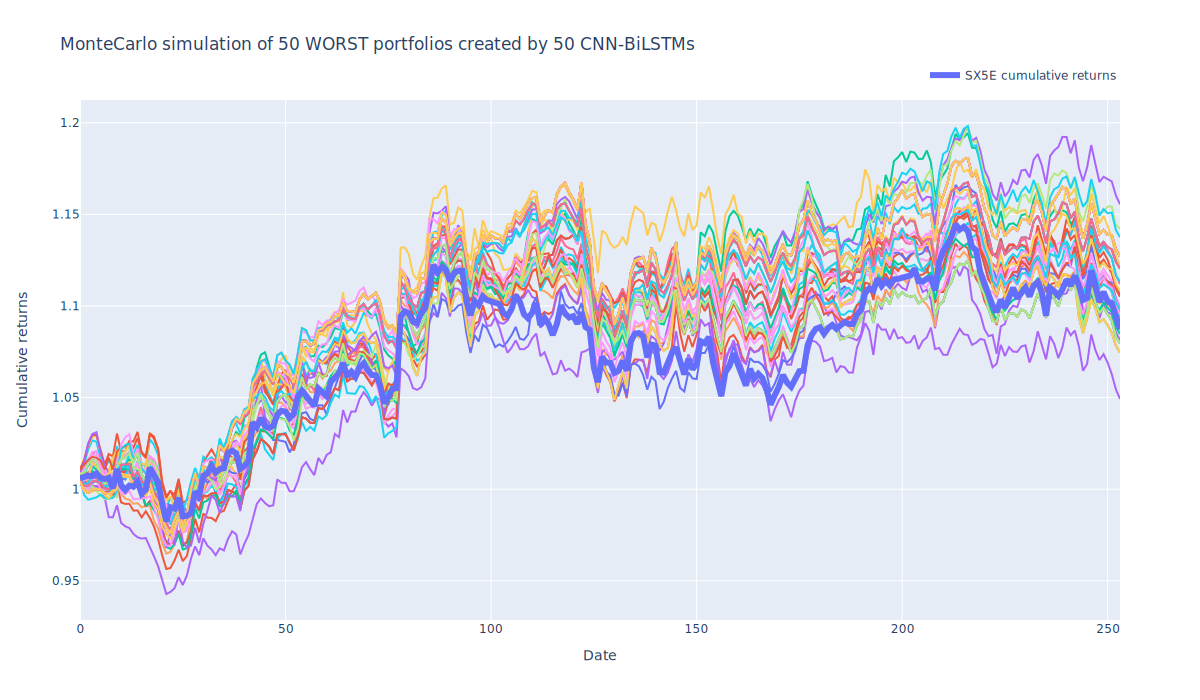

In [45]:
fig = go.Figure()

for series in worst_cumret1:
    fig.add_trace(go.Scatter(y=series, mode='lines', name='WORST portfolio', showlegend=False))

fig.add_trace(go.Scatter(y=(1+test_index_ret).cumprod(), mode='lines', name='SX5E cumulative returns', line=dict(width=6), showlegend=True))

fig.update_layout(
    title='MonteCarlo simulation of 50 WORST portfolios created by 50 CNN-BiLSTMs',
    xaxis_title='Date',
    yaxis_title='Cumulative returns',
    showlegend=True,
    width=1200,
    height=700,
    legend=dict(
        orientation="h",
        yanchor="bottom",
        y=1.02,
        xanchor="right",
        x=1)
    )

fig.show(renderer='svg')

---

### BiLSTM

In [46]:
# bilstm = Sequential(name='BiLSTM')
# bilstm.add(Bidirectional(LSTM(100, activation='relu', input_shape=(LOOK_BACK, n_features))))
# bilstm.add(RepeatVector(FORECAST_RANGE))
# bilstm.add(Bidirectional(LSTM(100, activation='relu', return_sequences=True)))
# bilstm.add(TimeDistributed(Dense(n_features)))

In [47]:
# bilstm.compile(optimizer='adam', loss='mse')

In [48]:
# history = bilstm.fit(X_train, y_train, epochs=30, batch_size=32)

Epoch 30/30

31/31 [==============================] - 1s 22ms/step - loss: 0.0010

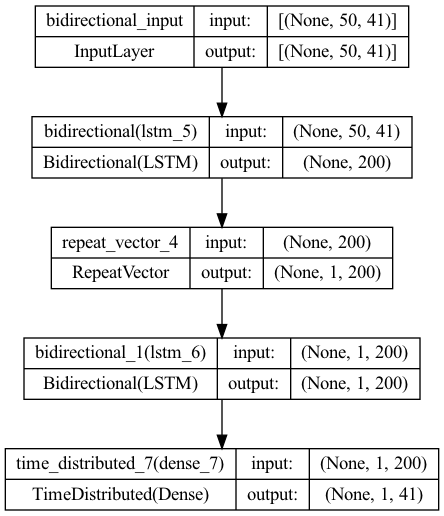

In [49]:
# bilstm.save('Models/BiLSTM.h5')
bilstm = load_model('Models/BiLSTM.h5')
plot_model(model=bilstm, show_shapes=True, to_file='model images/BiLSTM.png')

Now, theoretically, we need to suppress the backward pass of the bidirectional layers for testing/predicting. In out case we implemented a forecast() function that uses a single bacth of LOOK_BACK examples to predict the single next observation, thus we do not need to suppress the backward pass of the bidirectional layer since there are no examples to read backwards.

In [50]:
yhat = forecast(model=bilstm)

In [51]:
yhat_inverse, y_test_inverse = inverse_transform(y_test, yhat)

In [52]:
evaluate_forecast(y_test_inverse, yhat_inverse)

mae: nan
mse: nan
mape: nan


In [53]:
metrics_df = calculate_metrics(y_test_inverse, yhat_inverse, tukey)

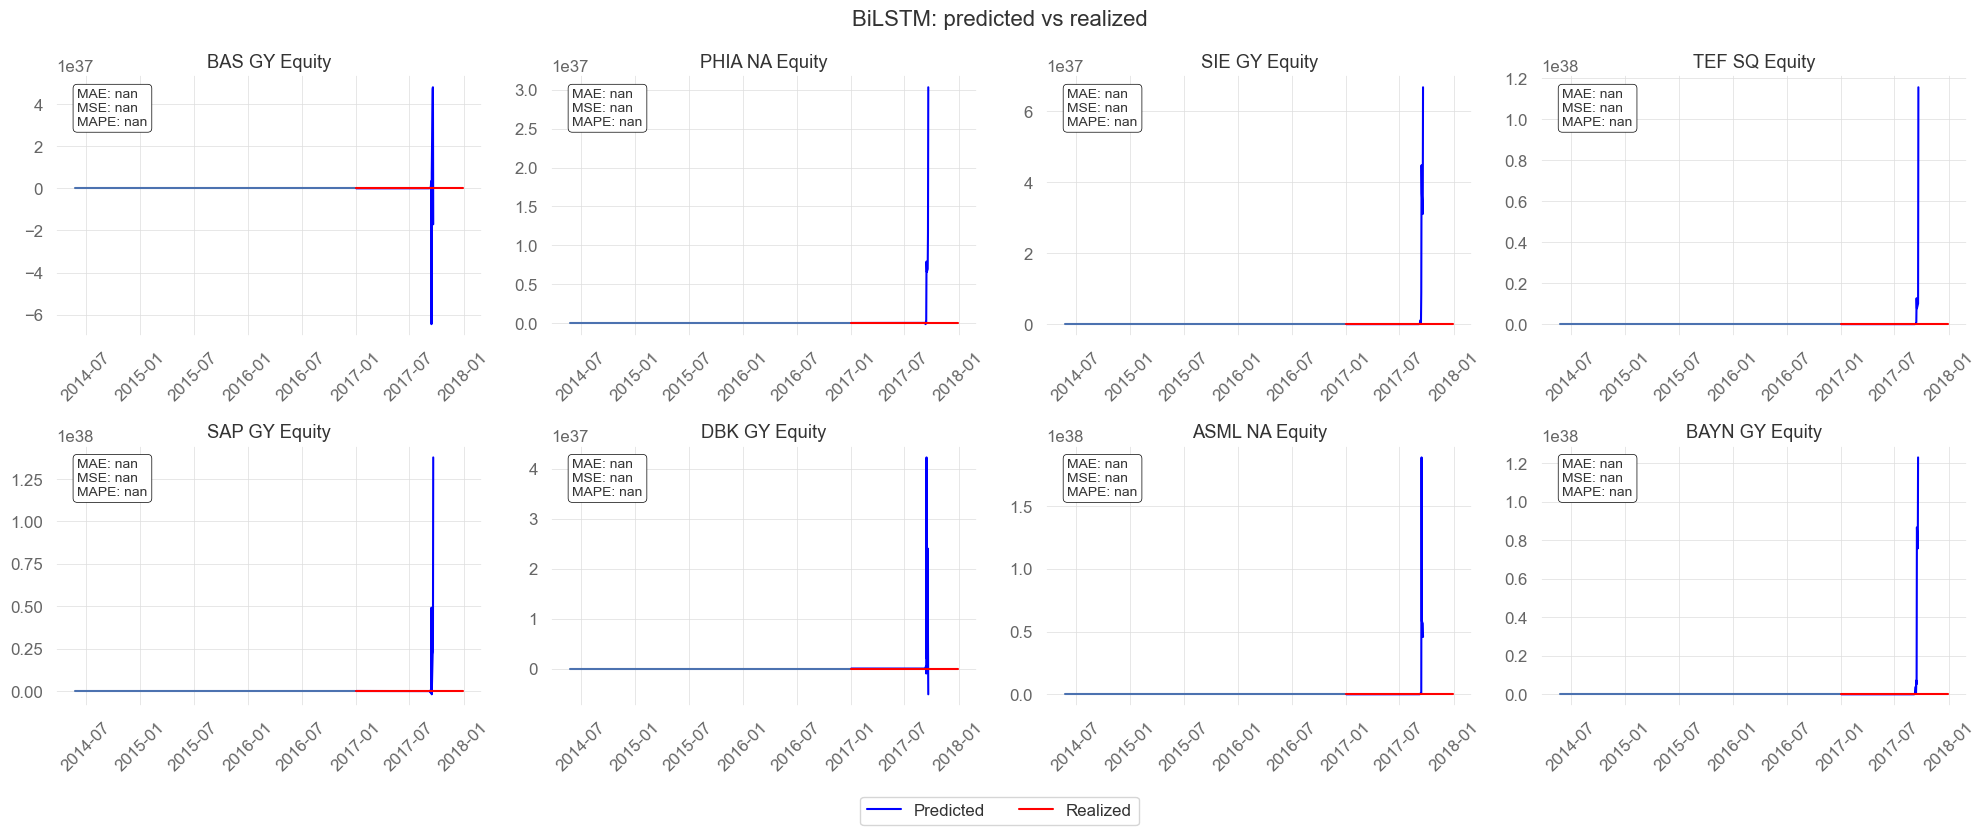

In [54]:
plot_preds(yhat_inverse, y_test_inverse, metrics_df, model_name=bilstm.name)

### Portfolio creation, optimization and comparison:

In [55]:
# convert to dataframes
yhat_inverse_df = pd.DataFrame(yhat_inverse, index=tukey.loc['2017-01-02':].index, columns=tukey.columns)
y_test_inverse_df = pd.DataFrame(y_test_inverse, index=tukey.loc['2017-01-02':].index, columns=tukey.columns)

In [56]:
ranking_BiLSTM = get_ranking(yhat_inverse_df, N = [5, 7, 10], prices=True)
 
perf_BiLSTM, portfolios_ret_BiLSTM = calc_portfolios(ranking_BiLSTM, stocks_returns.loc[yhat_inverse_df.index[0]:])

perf_BiLSTM['Index total performance'] = ((1 + test_index_ret).prod() - 1) * 100
perf_BiLSTM

{'Top 5 total performance': 5.122345863688871,
 'Top 7 total performance': 5.183097293593009,
 'Top 10 total performance': 8.823941207801877,
 'Index total performance': 8.73696808872011}

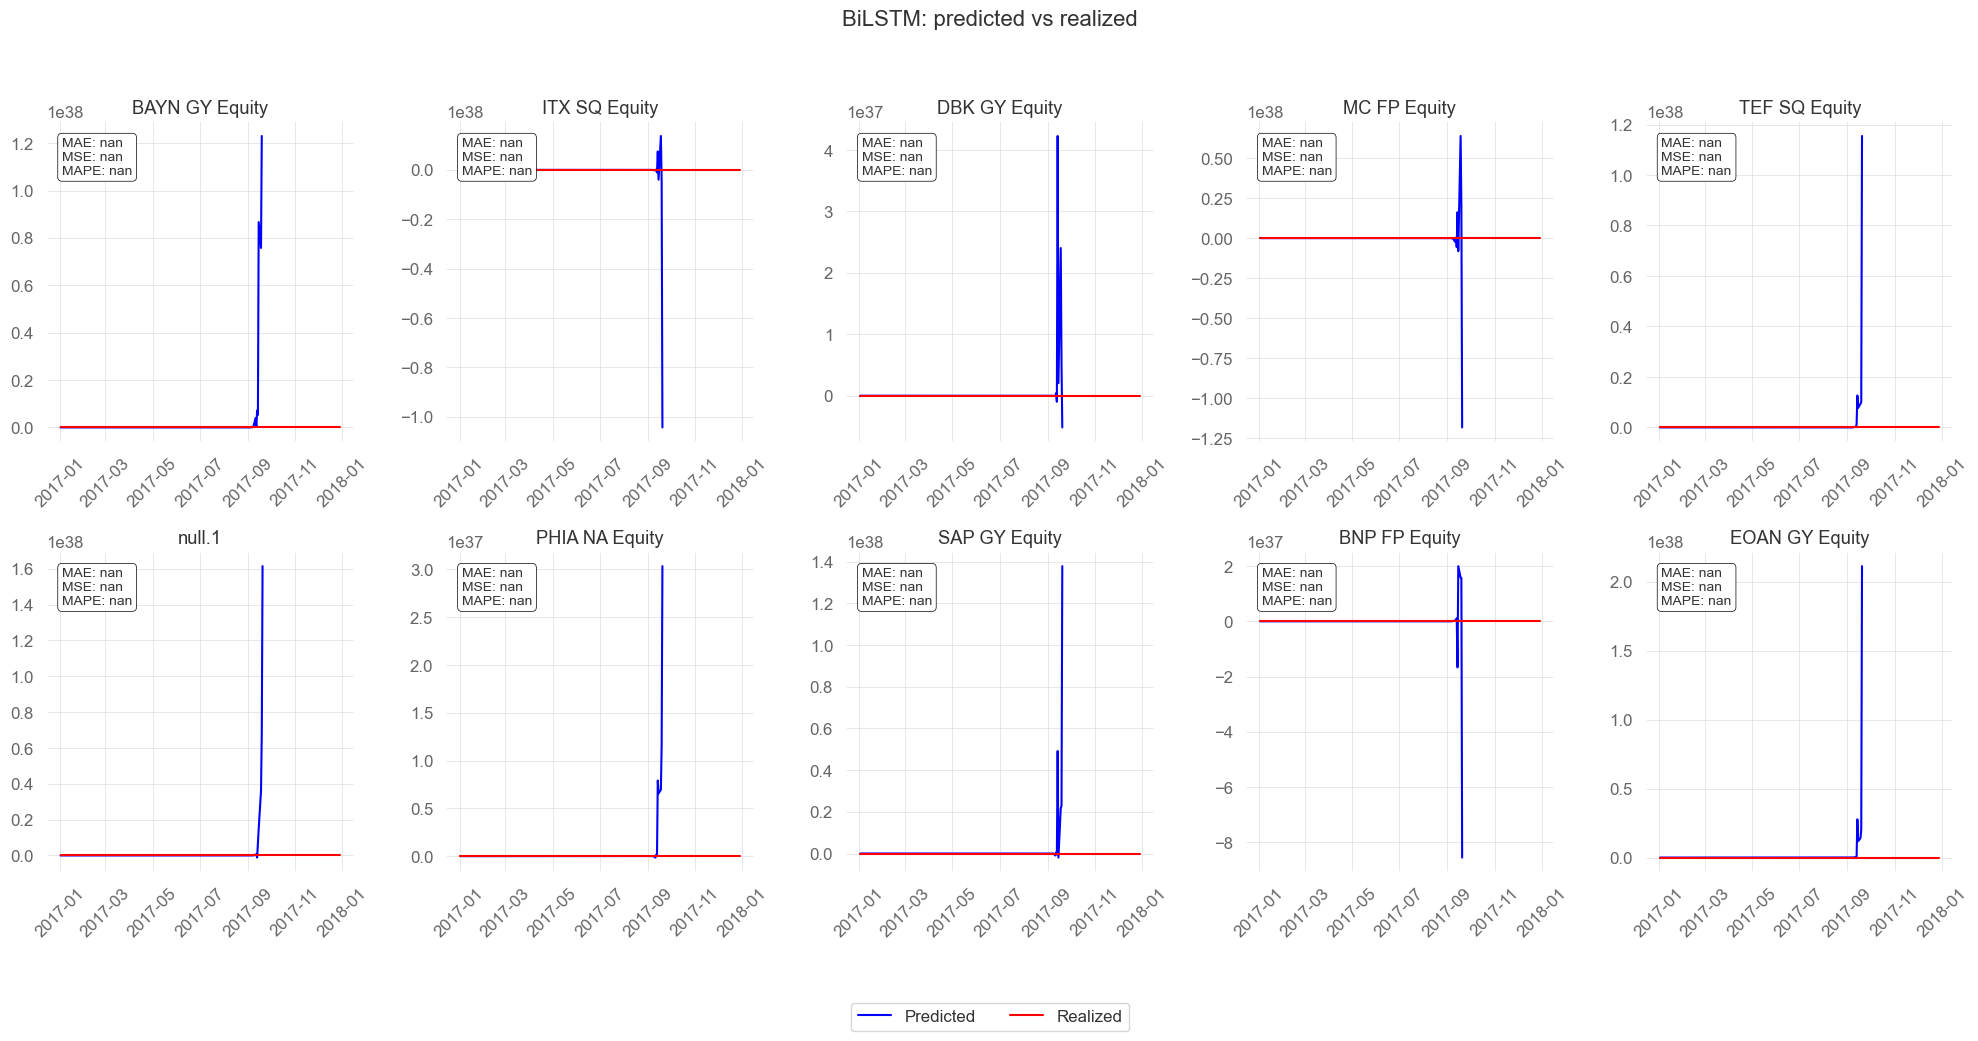

In [57]:
plot_top_N(yhat_inverse_df, y_test_inverse_df, 10, bilstm.name, metrics_df)

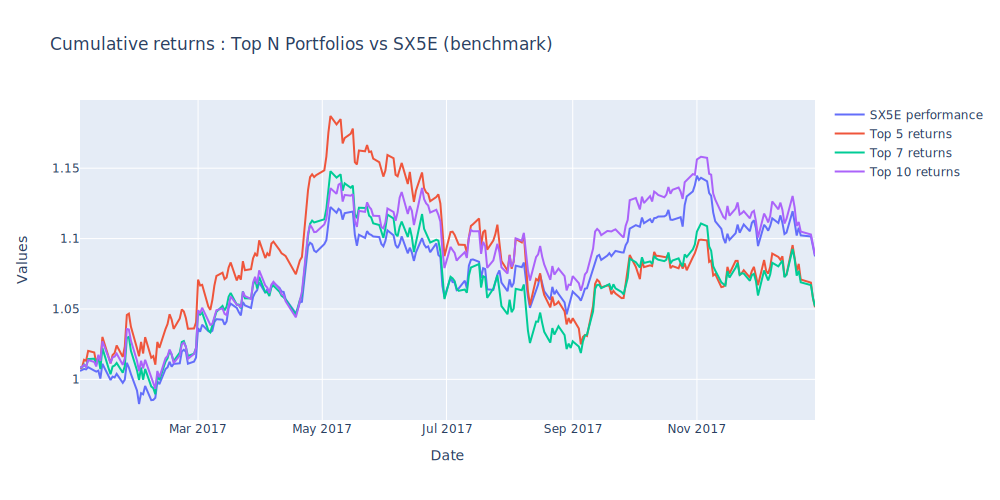

In [58]:
plot_portfolios(portfolios_ret_BiLSTM, test_index_ret, renderer=True)

Same prediction inconsistency of the LSTM. No MC simulations.

---

### CNN-BiLSTM

https://www.mdpi.com/2227-7072/10/3/64

In [59]:
# cnn_bilstm = Sequential(name = 'CNN-BiLSTM')

# # Deep CNN encoder
# cnn_bilstm.add(Conv1D(filters = 100, kernel_size = 3, input_shape=(LOOK_BACK, n_features)))
# cnn_bilstm.add(BatchNormalization())
# cnn_bilstm.add(ELU())
# cnn_bilstm.add(Conv1D(filters = 100, kernel_size = 5))
# cnn_bilstm.add(BatchNormalization())
# cnn_bilstm.add(ELU())
# cnn_bilstm.add(Conv1D(filters = 50, kernel_size = 7))
# cnn_bilstm.add(BatchNormalization())
# cnn_bilstm.add(ELU())
# cnn_bilstm.add(MaxPooling1D(pool_size=2))

# #
# cnn_bilstm.add(Flatten())
# cnn_bilstm.add(RepeatVector(FORECAST_RANGE))

# # BiLSTM
# cnn_bilstm.add(Bidirectional(LSTM(128, return_sequences=True)))     # sigmoid for gate state and tanh for state activations
# cnn_bilstm.add(Dropout(0.2))
# cnn_bilstm.add(Bidirectional(LSTM(64, return_sequences=True)))     # sigmoid for gate state and tanh for state activations
# cnn_bilstm.add(Dropout(0.2))
# cnn_bilstm.add(TimeDistributed(Dense(100, activation='relu')))
# cnn_bilstm.add(TimeDistributed(Dense(n_features)))

In [60]:
# cnn_bilstm.compile(optimizer='adam', loss='mse')

In [61]:
# history = cnn_bilstm.fit(X_train, y_train, epochs=40, batch_size=32)

Epoch 40/40

31/31 [==============================] - 1s 22ms/step - loss: 0.0035

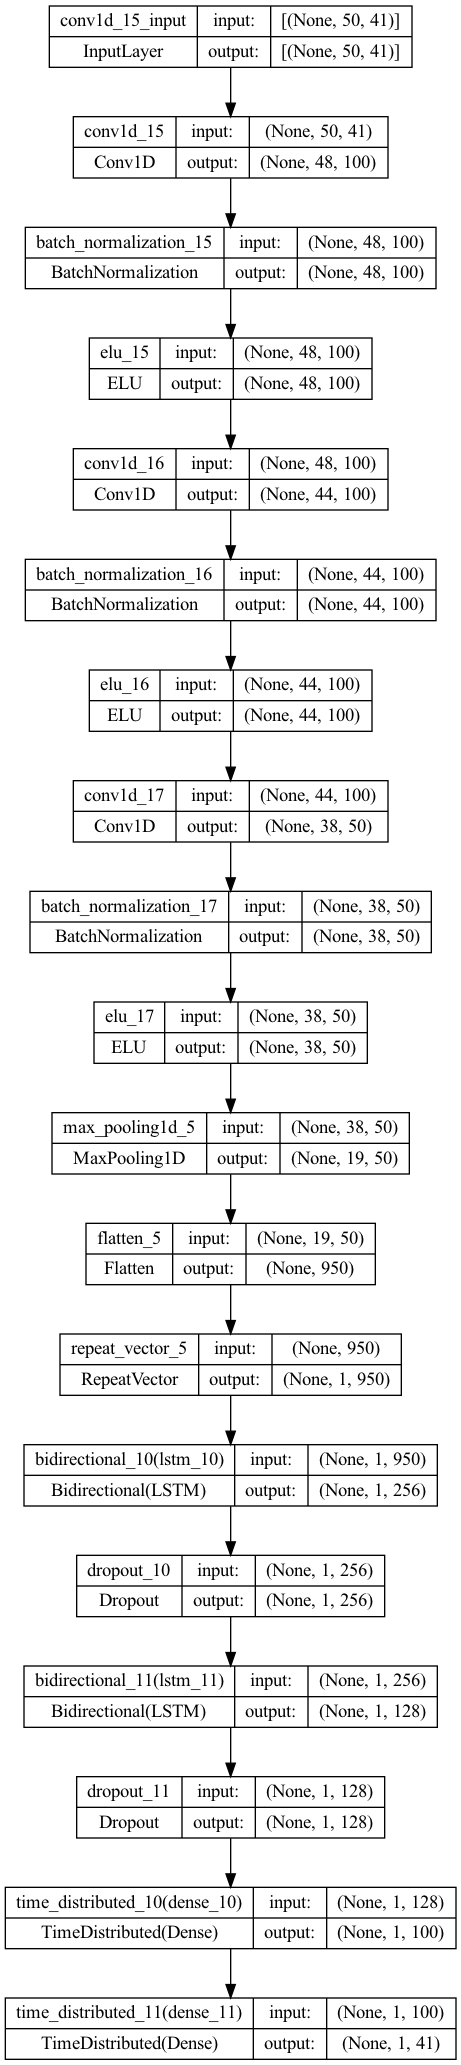

In [62]:
# cnn_bilstm.save('Models/CNN_BiLSTM.h5')
cnn_bilstm = load_model('Models/CNN_BiLSTM.h5')
plot_model(model=cnn_bilstm, show_shapes=True, to_file='model images/CNN_BiLSTM.png')

In [63]:
yhat = forecast(model=cnn_bilstm)

In [64]:
yhat_inverse, y_test_inverse = inverse_transform(y_test, yhat)

In [65]:
evaluate_forecast(y_test_inverse, yhat_inverse)

mae: 6.537466
mse: 157.31793
mape: 9.31694


In [66]:
metrics_df = calculate_metrics(y_test_inverse, yhat_inverse, tukey)

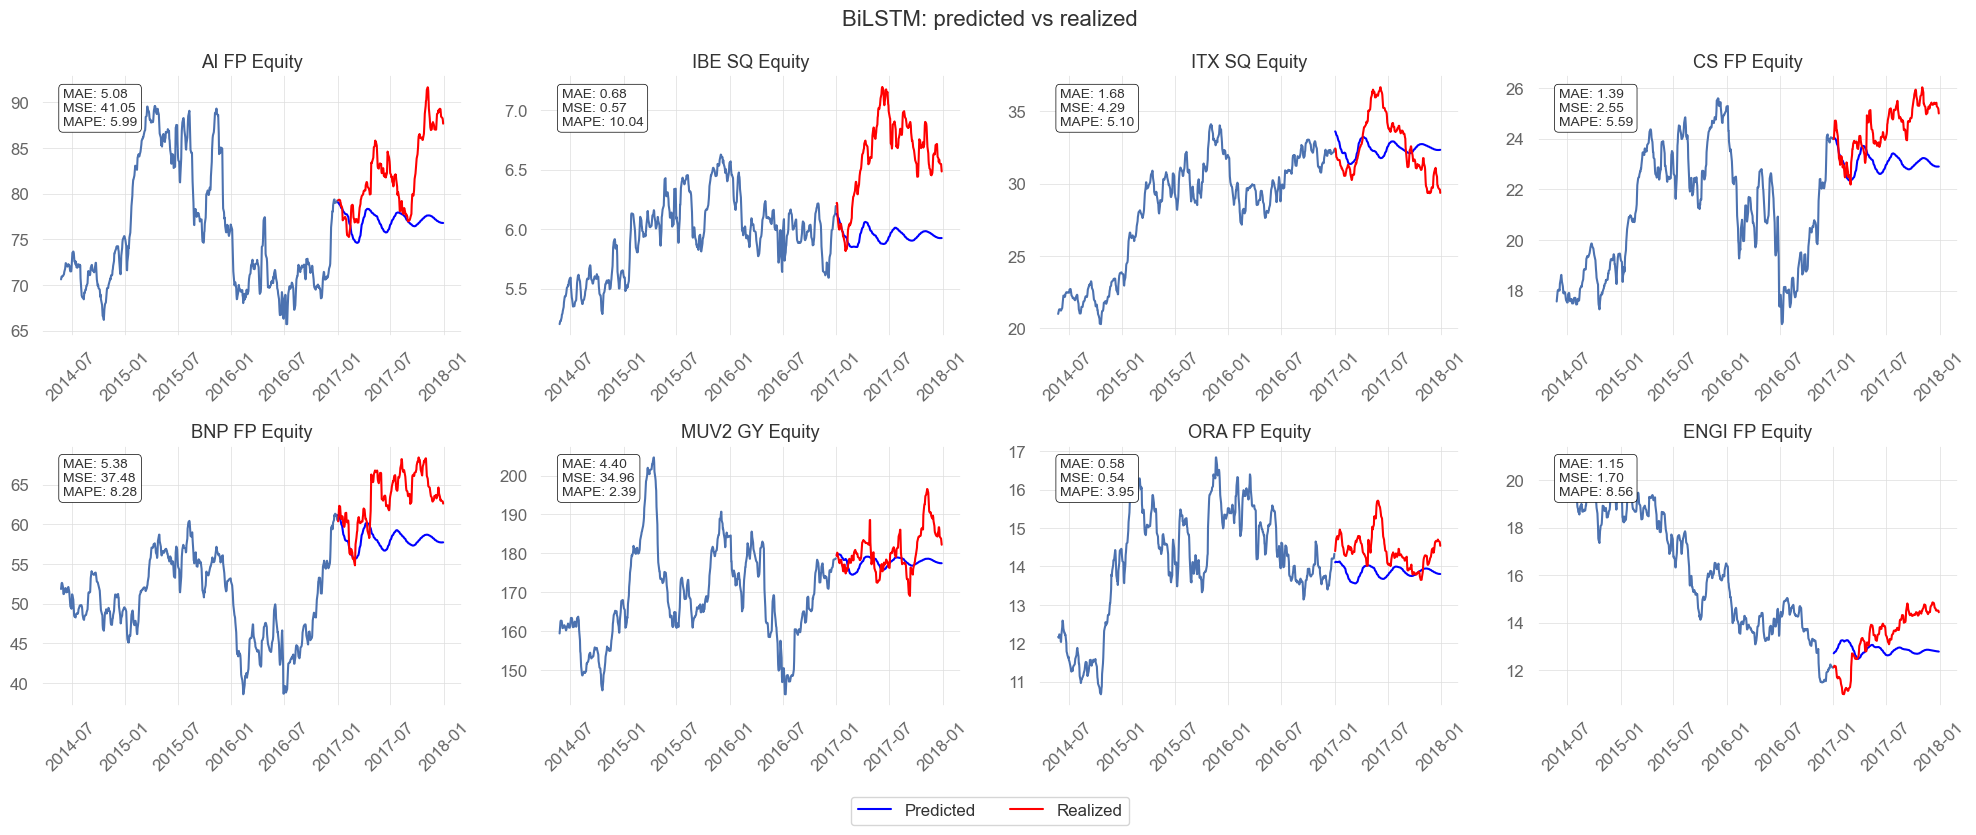

In [67]:
plot_preds(yhat_inverse, y_test_inverse, metrics_df, model_name=bilstm.name)

It looks like that the CNN encoder is fundamental for the non-exploding of the forecasts.

### Portfolio creation, optimization and comparison + pseudo-MC simulations:

In [68]:
# convert to dataframes
yhat_inverse_df = pd.DataFrame(yhat_inverse, index=tukey.loc['2017-01-02':].index, columns=tukey.columns)
y_test_inverse_df = pd.DataFrame(y_test_inverse, index=tukey.loc['2017-01-02':].index, columns=tukey.columns)

In [69]:
ranking_CNNBiLSTM = get_ranking(yhat_inverse_df, N = [5, 7, 10], prices=True)
 
perf_CNNBiLSTM, portfolios_ret_CNNBiLSTM = calc_portfolios(ranking_CNNBiLSTM, stocks_returns.loc[yhat_inverse_df.index[0]:])

perf_CNNBiLSTM['Index total performance'] = ((1 + test_index_ret).prod() - 1) * 100
perf_CNNBiLSTM

{'Top 5 total performance': 9.817229593442311,
 'Top 7 total performance': 12.674532106730751,
 'Top 10 total performance': 10.792471573333273,
 'Index total performance': 8.73696808872011}

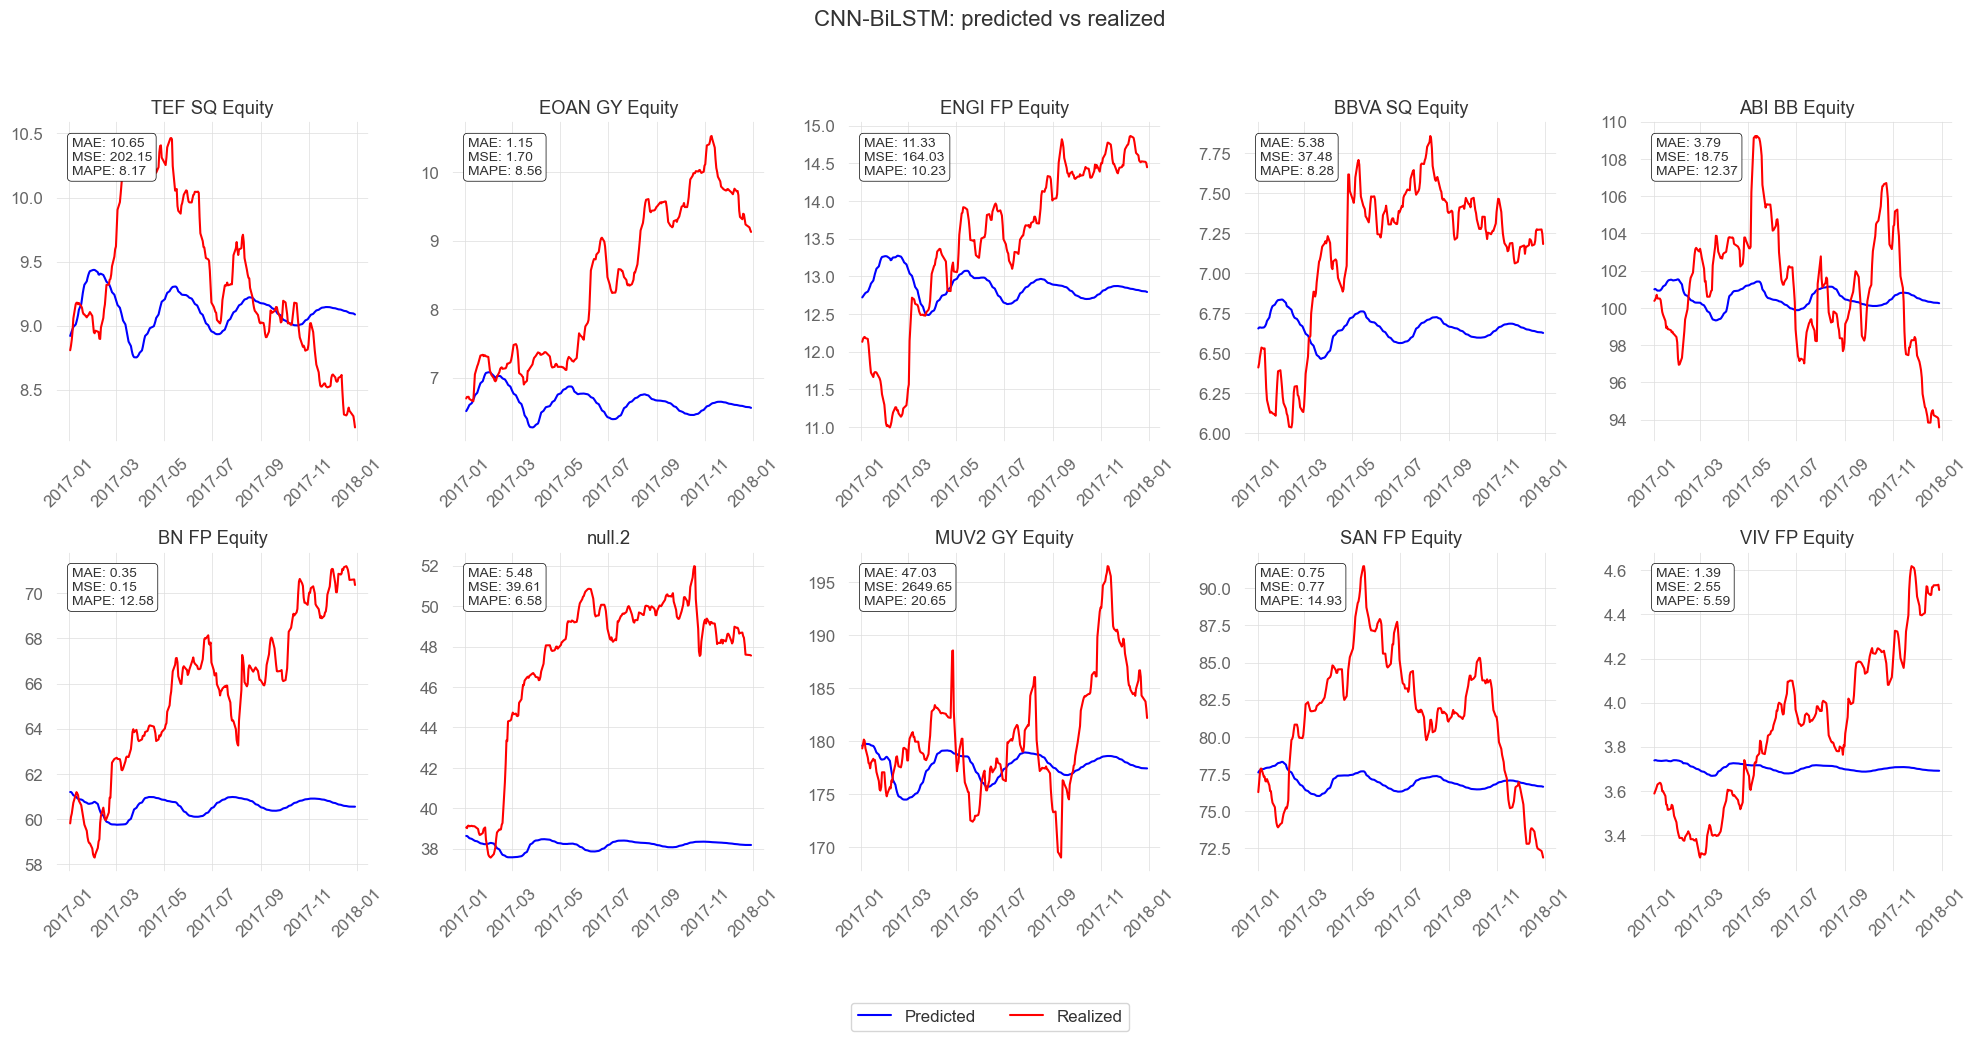

In [70]:
plot_top_N(yhat_inverse_df, y_test_inverse_df, 10, cnn_bilstm.name, metrics_df)

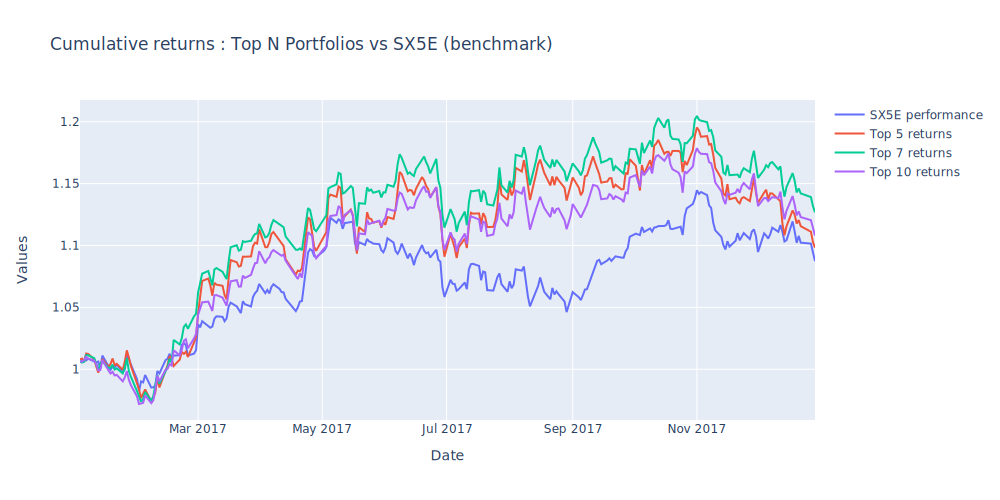

In [71]:
plot_portfolios(portfolios_ret_CNNBiLSTM, test_index_ret, renderer=True)

In [72]:
best_ret, best_cumret, best_list, best_perf, worst_ret, worst_cumret, worst_perf = MC_portfolios(model_initialized=cnn_bilstm,
                                                                                                n_sim=50, 
                                                                                                X_train=X_train, y_train=y_train, 
                                                                                                X_test=X_test, y_test=y_test, 
                                                                                                stocks_returns=stocks_returns, 
                                                                                                date_index=tukey.loc['2017-01-02':].index, 
                                                                                                stocks_names=tukey.columns, 
                                                                                                LOOK_BACK=LOOK_BACK)

{'Top 5 total performance': 10.66405641564776, 'Top 7 total performance': 6.5348363896734485, 'Top 10 total performance': 8.927121829852469}
1/50 

{'Top 5 total performance': 10.677039623529993, 'Top 7 total performance': 15.733397450799046, 'Top 10 total performance': 12.316325818038742}
2/50 

{'Top 5 total performance': 5.5930545956811795, 'Top 7 total performance': 11.504948314344698, 'Top 10 total performance': 10.806400878214317}
3/50 

{'Top 5 total performance': 13.333768869623519, 'Top 7 total performance': 11.504948314344698, 'Top 10 total performance': 12.93730061825553}
4/50 

{'Top 5 total performance': 4.7138573585762344, 'Top 7 total performance': 7.735655316234147, 'Top 10 total performance': 11.51768344883186}
5/50 

{'Top 5 total performance': 5.46797719969494, 'Top 7 total performance': 5.414956289166484, 'Top 10 total performance': 9.21896607422552}
6/50 

{'Top 5 total performance': 5.46797719969494, 'Top 7 total performance': 5.414956289166484, 'Top 10 total perf

In [73]:
compare_MC(test_index_ret, best_ret, best_perf, worst_ret, worst_perf, best_list)

Number of times an N-portfolio was the best performing: 


,Top,Frequency
2,7,23
0,10,15
1,5,12




Average metrics of best portfolio & worst portfolio vs SX5E metrics


,Benchmark,Best performing,Worst performing
Sharpe ratio,0.885662,0.919522,0.646870
Max_drawdown,-6.794479,-6.136727,-6.302096
Annualized Return,9.275149,10.899095,7.482505
Annualized Vol,9.937853,11.072952,11.001512




Min and max performance of BEST and WORST performing portfolios


,Min,Max
Best performing,5.467977,17.643426
Worst performing,3.542490,12.937301




Frequency of Worst performing portfolios with performance smaller than SX5E performance:  33


Seems like CNN-LSTM is the best strategy among the proposed ones.

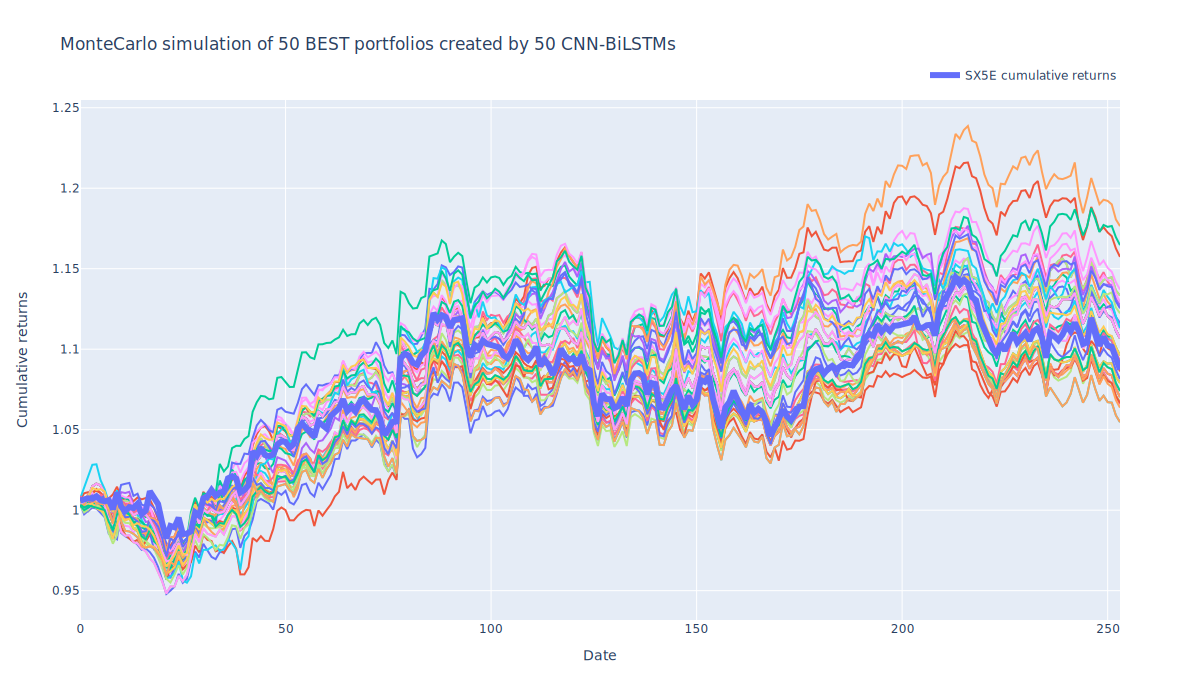

In [74]:
fig = go.Figure()

for series in best_cumret:
    fig.add_trace(go.Scatter(y=series, mode='lines', name='BEST portfolio', showlegend=False))

fig.add_trace(go.Scatter(y=(1+test_index_ret).cumprod(), mode='lines', name='SX5E cumulative returns', line=dict(width=6), showlegend=True))

fig.update_layout(
    title='MonteCarlo simulation of 50 BEST portfolios created by 50 CNN-BiLSTMs',
    xaxis_title='Date',
    yaxis_title='Cumulative returns',
    showlegend=True,
    width=1200,
    height=700,
    legend=dict(
        orientation="h",
        yanchor="bottom",
        y=1.02,
        xanchor="right",
        x=1)
    )

fig.show(renderer='svg')

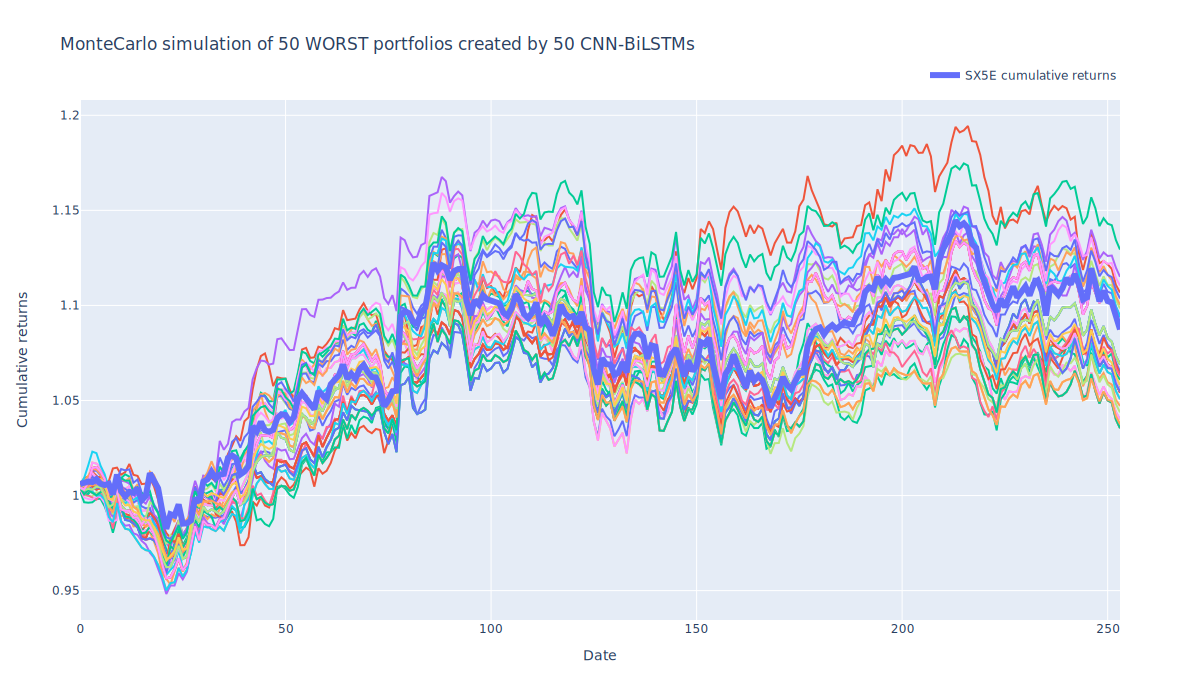

In [75]:
fig = go.Figure()

for series in worst_cumret:
    fig.add_trace(go.Scatter(y=series, mode='lines', name='WORST portfolio', showlegend=False))

fig.add_trace(go.Scatter(y=(1+test_index_ret).cumprod(), mode='lines', name='SX5E cumulative returns', line=dict(width=6), showlegend=True))

fig.update_layout(
    title='MonteCarlo simulation of 50 WORST portfolios created by 50 CNN-BiLSTMs',
    xaxis_title='Date',
    yaxis_title='Cumulative returns',
    showlegend=True,
    width=1200,
    height=700,
    legend=dict(
        orientation="h",
        yanchor="bottom",
        y=1.02,
        xanchor="right",
        x=1)
    )

fig.show(renderer='svg')